In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import scipy.sparse as sp
import mps_loader
import pandas as pd
import gc
import trustregionutil as tr
from sklearn.decomposition import PCA
%load_ext autoreload
%autoreload 2

# Loading the problem

In [7]:
#Loading the problem (https://plato.asu.edu/ftp/lptestset/fctp/)
mps=mps_loader.read_mps('MPS/ran10x10b.mps')
#mps=mps_loader.read_mps('MPS/bk4x3.mps')
#mps=mps_loader.read_mps('MPS/ran17x17.mps')
#mps=mps_loader.read_mps('MPS/n370a.mps')
c,A,b,G,h,l,u=mps_loader.mps_parsing(mps)

reading mps


In [11]:
c,A,b,G,h,l,u=mps_loader.small_lp1()
c,A,b,G,h,l,u=mps_loader.small_lp2()

In [12]:
K=sp.vstack([G,A])
q=np.vstack([h,b])
dim=c.shape[0]
m1=G.shape[0]
m2=A.shape[0]

In [13]:
#SOLVING WITH SCIPY
#The lin prog solver of scipy assumes the inequality constraint to be a lower bound, and c the objective 
#map has to be transposed
opt = linprog(c=c.T, A_ub=-G, b_ub=-h.T,
             A_eq=A, b_eq=b.T, bounds=np.hstack([l,u]),
           method="highs")
opt

           con: array([0.])
 crossover_nit: 0
         eqlin:  marginals: array([-1.6])
  residual: array([0.])
           fun: -17.6
       ineqlin:  marginals: array([-0.2, -0. ])
  residual: array([0. , 5.6])
         lower:  marginals: array([0. , 0. , 2.8])
  residual: array([5.2, 2.4, 0. ])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 2
         slack: array([0. , 5.6])
        status: 0
       success: True
         upper:  marginals: array([0., 0., 0.])
  residual: array([4.8, 1.6, 5. ])
             x: array([5.2, 2.4, 0. ])

In [14]:
x_sol=opt.x.reshape(-1,1)
print(dim,m1,m2)

3 2 1


In [36]:
#UTILITY FUNCTIONS
def plot_residuals(list_list,labels=None,title=None,thresh=16):
    if not labels:
        labels=["","","","","","",""]
    try:
        for i,list_ in enumerate(list_list):
            if i==0:
                y=list_[20:]
                y=[x if x > 0 else 10**-thresh for x in y]
                x=np.linspace(0,1,len(y))
                a,b=np.polyfit(x, np.log(y), 1)
                plt.plot(y,label=labels[i])
                plt.plot(np.exp(a*x+b),label='{:.3}*exp({:.3} * x)'.format(np.exp(b),a))
            else:
                y=list_[20:]
                y=[x if x > 0 else 10**-thresh for x in y]
                plt.plot(y,label=labels[i])
        ax=plt.gca()
        ax.set_yscale('log')
        plt.legend()
        if title:
            plt.title(title)
        plt.show()
    except:
        pass

def VisuIterate(list_list_iterate,x_sol,y_sol,dim,m1,m2,down,up,colors=None,markers=None,labels=None,zorders=None,ss=None):
    if not colors:
        colors=['blue','green','red','yellow','purple','brown']
    if not labels:
        labels=['','','','','','']
    if not markers:
        markers=['+','x','1','2','3','4']
    if not zorders:
        zorders=[0,0,0,0,0,0]
    if not ss:
        ss=[10,10,10,10,10,10]
        
    for i,list_iterate in enumerate(list_list_iterate):
        if i==0:
            xs=np.array(list_iterate)[:,:dim]
            ys=np.array(list_iterate)[:,dim:]
        else:
            xs=np.vstack([xs,np.array(list_iterate)[:,:dim]])
            ys=np.vstack([ys,np.array(list_iterate)[:,dim:]])
            
    xs=np.append(xs,x_sol.reshape(-1,dim)).reshape(-1,dim)
    ys=np.append(ys,y_sol.reshape(-1,m1+m2)).reshape(-1,m1+m2)
        
    pca = PCA(n_components=1) 
    xs_fit = pca.fit_transform(xs)  
    ys_fit = pca.fit_transform(ys)
    
    for i,list_iterate in enumerate(list_list_iterate):
        x=xs_fit[:len(list_iterate)]
        y=ys_fit[:len(list_iterate)]
        xs_fit=xs_fit[len(list_iterate):]
        ys_fit=ys_fit[len(list_iterate):]
        plt.scatter(x=x[down:up],y=y[down:up],s=ss[i],color=colors[i],marker=markers[i],label=labels[i],zorder=zorders[i])
    
    x_sol_fit=xs_fit[-1]
    y_sol_fit=ys_fit[-1]
    plt.scatter(x=x_sol_fit,y=y_sol_fit,color='black',s=100,marker='x',label='solution',zorder=200)
    plt.legend()
    plt.show()
    
def cum_mean(arr):
    cum_sum = np.cumsum(arr, axis=0)    
    for i in range(cum_sum.shape[0]):       
        if i == 0:
            continue        
        cum_sum[i] =  cum_sum[i] / (i + 1)
    return cum_sum

def SpectraRadius(M):
    '''
        Computes the spectral radius of a symmetric matrix i.e. its greater eigenvalue (in absolute value)
    '''
    return np.max(np.abs(np.linalg.eig(M)[0]))

def SpectraRadius(M):
    '''
        Computes the spectral radius of a symmetric sparse matrix i.e. its greater eigenvalue (in absolute value)
    '''
    return abs(sp.linalg.eigsh(M.asfptype(), k=1,which='LM')[0]).max()

def ProjLambda(lambda_: np.array, l: np.array, u: np.array):
    '''
    Λ = Λ1 × · · · × Λn 
    Λi:= {0} if li = −∞, ui = ∞,
         R− if li = −∞, ui ∈ R
         R+ if li ∈ R, ui = ∞
         R otherwise
    '''
    assert lambda_.shape == l.shape
    assert lambda_.shape == u.shape
    proj=np.zeros(lambda_.shape)
    proj[np.where((l==-np.inf)&(u!=np.inf))]=np.minimum(lambda_[np.where((l==-np.inf)&(u!=np.inf))],0)
    proj[np.where((l!=-np.inf)&(u==np.inf))]=np.maximum(lambda_[np.where((l!=-np.inf)&(u==np.inf))],0)
    proj[np.where((l!=-np.inf)&(u!=np.inf))]=lambda_[np.where((l!=-np.inf)&(u!=np.inf))]
    
    return proj

def dot_product(a, b):
    result = 0
    for i in range(len(a)):
        if np.isinf(a[i]) and b[i] == 0:
            result += 0
        elif np.isinf(b[i]) and a[i] == 0:
            result += 0
        else:
            result += a[i] * b[i]
    return result

def calculate_residuals(z,z_new,K,sigma,tau,dim):
    x_new=z_new[:dim]
    y_new=z_new[dim:]
    x=z[:dim]
    y=z[dim:]

    p=np.sum(np.abs((x-x_new)/tau-K.T.dot(y-y_new)))
    d=np.sum(np.abs((y-y_new)/sigma-K.dot(x-x_new)))
    return p,d


def compute_kkt_error(current_sol: np.array,c: np.array,G: np.array,A: np.array,b: np.array,l: np.array,
                        u: np.array, dim: int):
    
    '''
       |qt.y + lt.λ+ − ut.λ− − ct.x|  +
       
       || Ax − b  ||                  
       ||(h − Gx) ||                  
       
       + ||c − Kt.y − λk||              
    '''
    
    x=current_sol[:dim]
    y=current_sol[dim:]
    

    #Defining the saddle point problem variables
    K=sp.vstack([G,A])
    q=np.vstack([h,b])
    m1=G.shape[0]
    m2=A.shape[0]
    

    
    #The PDHG algorithm does not explicitly include a reduced costs variable λ.
    #Therefore, to evaluate the optimality termination criteria we compute:
    lambda_=ProjLambda(c-K.T.dot(y),l,u)
    
    duality_gap=np.abs(q.T.dot(y) + dot_product(l,np.maximum(lambda_,0)) - dot_product(u,-np.minimum(lambda_,0)) - c.T.dot(x))
    duality_gap=duality_gap.flatten()[0]
    
    mat_concat=np.vstack([A.dot(x)-b,np.maximum(h-G.dot(x),0)])
    primal_feasibility=np.linalg.norm(mat_concat)
   

    dual_feasibility=np.linalg.norm(c-K.T.dot(y)-lambda_)
    return duality_gap+primal_feasibility+dual_feasibility

def TerminationCriteria(current_sol: np.array,c: np.array,G: np.array,A: np.array,b: np.array,l: np.array,
                        u: np.array, tol: float, dim: float, verbose :  bool):
    
    '''
       |qt.y + lt.λ+ − ut.λ− − ct.x|   ≤    eps(1 + |qt.y + lt.λ+ − ut.λ−| + |ct.x|) (6a)
       
       || Ax − b  ||                   ≤    eps(1 + ||q||)                           (6b)
       ||(h − Gx) ||                  
       
       ||c − Kt.y − λk||               ≤    eps(1 + ||c||)                           (6c)
    '''
    
    x=current_sol[:dim]
    y=current_sol[dim:]
    
         
    #Defining the saddle point problem variables
    K=sp.vstack([G,A])
    q=np.vstack([h,b])
    m1=G.shape[0]
    m2=A.shape[0]
    
  
    
    #The PDHG algorithm does not explicitly include a reduced costs variable λ.
    #Therefore, to evaluate the optimality termination criteria we compute:
    lambda_=ProjLambda(c-K.T.dot(y),l,u)
    
    temp_left=np.abs(q.T.dot(y) + dot_product(l,np.maximum(lambda_,0)) - dot_product(u,-np.minimum(lambda_,0)) - c.T.dot(x))
    temp_right=1 + np.abs(q.T.dot(y) + dot_product(l,np.maximum(lambda_,0)) - dot_product(u,-np.minimum(lambda_,0))) + np.abs(c.T.dot(x))
    
    #if verbose:
    #    print('lambda:',lambda_)
    #    print('crit1left:',temp_left,'crit1right:',temp_right)
    #    print(q.T.dot(y))
    #    print('dual value:',q.T.dot(y) + dot_product(l,np.maximum(lambda_,0)) - dot_product(u,-np.minimum(lambda_,0)),'Primal value',c.T.dot(x))
    criteria1=temp_left <= tol * temp_right
    
    mat_concat=np.vstack([A.dot(x)-b,np.maximum(h-G.dot(x),0)])
    temp_left2=np.linalg.norm(mat_concat)
    temp_right2=(1 + np.linalg.norm(q))

    criteria2=temp_left2 <= tol * temp_right2
    
    
    temp_left3=np.linalg.norm(c-K.T.dot(y)-lambda_)
    temp_right3=(1 + np.linalg.norm(c))
    criteria3=temp_left3 <= tol * temp_right3
    
    if criteria1&verbose:
        print('Termination Criteria 1 Reached')
        
    if criteria2&verbose:
        print('Termination Criteria 2 Reached')
        
    if criteria3&verbose:
        print('Termination Criteria 3 Reached')
    
    
    return criteria1,criteria2,criteria3



def check_solution(x,c,A,G,h,b,l,tol=10**-4):
    function_value=c.T.dot(x).flatten()[0]
    print("Minimum found:",function_value)
    ineq_left=G.dot(x)
    ineq_right=h
    ineq_verified=np.sum(ineq_left-ineq_right>=-tol)
    print("\nInequality constraints verified:",ineq_verified,"/",len(h),"\nGx=",ineq_left.T,"\nShould be greater then:",ineq_right.T)
    eq_left=A.dot(x)
    eq_right=b
    eq_verified=np.sum(np.abs(eq_left-eq_right)<tol)
    print("\nEquality constraints verified:",eq_verified,"/",len(eq_right),"\nAx=",eq_left.T,"\nShould be equal to:",eq_right.T)
    bound_verified=np.sum((l<=x)&(x<=u))
    print("\nBound verified:",bound_verified,"/",len(l),"\nLower bound:",l.T,"\nx:",x.T, "\nUpper bound:",u.T)
    return
    
def wnorm(x: np.array, y : np.array, w):
    return np.sqrt(w * np.linalg.norm(x)**2 + 1/w*np.linalg.norm(y)**2)

def Lagrangian(x: np.array, y: np.array, c :np.array, K: np.array, q: np.array):
    '''
         L(x,y)=ctx − ytKx + qty 
    '''
    L=c.T.dot(x) - np.dot(y.T,K.dot(x)) + q.T.dot(y)
    return np.ndarray.flatten(L)[0]

def ComputePrimalGradient( y: np.array, c :np.array, K: np.array):
    return c-K.T.dot(y)

def ComputeDualGradient(x: np.array, K: np.array, q: np.array):
    return q-K.dot(x)

def NormalizedDualityGap(x: np.array, y: np.array, c :np.array, K: np.array, q: np.array,l: np.array, u: np.array, 
                         w: float,r: float):
    
    
    return

def ProjLowerUpper(x: np.array , l: np.array, u: np.array):
    return np.minimum(np.maximum(x,l),u)


def InitializePrimalWeight(c: np.array, q: np.array, eps0: float):
    if (np.linalg.norm(c)>eps0) and (np.linalg.norm(q)>eps0):
        return np.linalg.norm(c)/np.linalg.norm(q)
    
    else:
        return 1
    
def CalculateResiduals(c,K,q,x,y):
    p=np.sum(np.abs(c+K.T.dot(y)))
    d=np.sum(np.abs(K.dot(x)-q))
    return p,d
    
    
def PrimalWeightUpdate(current_sol: np.array, previous_sol: np.array, eps0: float, previous_primal_weight: float, dim: int):
    '''
        See Section 3.3 of ref
    '''
    x_current=current_sol[:dim]
    y_current=current_sol[dim:]
    
    x_previous=previous_sol[:dim]
    y_previous=previous_sol[dim:]
    
    deltax=np.linalg.norm(x_current-x_previous)
    deltay=np.linalg.norm(y_current-y_previous)
    
    if (deltax > eps0) and (deltay > eps0):
        return np.exp(0.5 * np.log(deltay / deltax) + (0.5 * np.log(previous_primal_weight)))
    else:
        return previous_primal_weight

def compute_mu(z: np.array,z_ref:np.array , c :np.array, G: np.array, A:np.array, b:np.array,h:np.array,
               l: np.array,u: np.array, w: float):
    '''
        ρ^n_r(z) := 1/r maximize(ˆx,yˆ)∈{zˆ∈Z:||zˆ−z||_{ωn} ≤ r} {L(x, yˆ) − L(ˆx, y)},
        µn(z, zref) := ρ^n_{||z−zref||_ωn}(z)
        returns µn(z, zref)
    '''
   

    #Defining the saddle point problem variables
    K=sp.vstack([G,A])
    q=np.vstack([h,b])
    m1=G.shape[0]
    m2=A.shape[0]
   
    
    norm_weights=np.zeros(len(z))
    norm_weights[:dim]=w
    norm_weights[dim:]=1/w
    r=tr.weighted_norm(z-z_ref,norm_weights).flatten()[0]
    
    x=z[:dim]
    y=z[dim:]
    
    primal_tr_solution,dual_tr_solution=tr.solve_normalised_duality_gap(c, G, A, b, h, l, u,
                            x, y, norm_weights, r)
    
    normalised_duality_gap=1/r*(Lagrangian(x,dual_tr_solution,c,K,q)-Lagrangian(primal_tr_solution,y,c,K,q))
    
    return normalised_duality_gap
    
def GetRestartCandidate(z,z_bar,z0,c, G, A, b,h,l,u, w):
    if compute_mu(z, z0, c, G, A, b,h,l,u, w) < compute_mu(z_bar, z0, c, G, A, b,h,l,u, w):
        return z
    else:
        return z_bar
    
def RestartCriteria(z_old_c,z_new_c,z0_old,z0,c, G, A, b,h,l,u, w,t,k,beta_s=0.9,beta_n=0.1,beta_a=0.5):
    '''
        (i) (Sufficient decay in normalized duality gap) µn(zn_t+1_c, zn,0) ≤ βsufficient * µn(zn_0, zn−1_0) ,
        (ii) (Necessary decay + no local progress in normalized duality gap)µn(zn,t+1c, zn,0) ≤ βnecessary * µn(zn_0, zn−1_0) 
            and µn(zn_t+1_c, zn_0) > µn(zn_t_c, zn_0) ,
        (iii) (Long inner loop) t ≥ βartificial * k .
    '''
    
    crit1=compute_mu(z_new_c, z0, c, G, A, b,h,l,u, w) <= beta_s * compute_mu(z0, z0_old, c, G, A, b,h,l,u, w)
    crit2=(compute_mu(z_new_c, z0, c, G, A, b,h,l,u, w) <= beta_n * compute_mu(z0, z0_old, c, G, A, b,h,l,u, w)) and \
            (compute_mu(z_new_c, z0, c, G, A, b,h,l,u, w) > compute_mu(z_old_c, z0, c, G, A, b,h,l,u, w))
    crit3=t >= beta_a * k
    
    return (crit1 or crit2 or crit3)
    

def StepPDHG(zn,c,K,q,l,u,tau,sigma,dim,m1):
    '''
    x′ ← projX (x − τ (c − Kt y)) ;
    y′ ← projY (y + σ (q − K(2x′ − x))) 
    '''
    x=zn[:dim]
    y=zn[dim:]
    
    x_new=x - tau * (c - K.T.dot(y)) 
    #projecting on X
    x_new=ProjLowerUpper(x_new,l,u)
    
    y_new=y + sigma * (q - K.dot((2*x_new-x)))
    #Projecting on Y
    y_new[0:m1]=np.maximum(y_new[0:m1],0)
    
    z_new=np.vstack([x_new,y_new])
    return z_new

def StepPDLP(z,c,K,q,l,u,eta,w,dim,m1):
    
    x=z[:dim]
    y=z[dim:]
    
   
    x_new=x - eta/w * (c - K.T.dot(y)) 
    #projecting on X
    x_new=ProjLowerUpper(x_new,l,u)
    
    
    
    y_new=y + eta*w * (q - K.dot((2*x_new-x)))
    #Projecting on Y
    y_new[0:m1]=np.maximum(y_new[0:m1],0)

      
    z_new=np.vstack([x_new,y_new])
    return z_new

    

def AdaptativeStepPDHG(zn,c,K,q,l,u,eta,w_n,dim,m1,k):
    
    x=zn[:dim]
    y=zn[dim:]
  
    while True:
        x_new=x - eta/w_n * (c - K.T.dot(y)) 
        #projecting on X
        x_new=ProjLowerUpper(x_new,l,u)
        
        y_new=y + eta*w_n * (q - K.dot((2*x_new-x)))
        #Projecting on Y
        y_new[0:m1]=np.maximum(y_new[0:m1],0)
        
        if wnorm(x-x_new,y-y_new,w_n)**2 >1e-10:
            rhs=(2 * (y_new-y).T.dot(K.dot(x_new-x)).flatten()[0])/wnorm(x-x_new,y-y_new,w_n)**2 
            backtracking=1/eta > rhs
        else:
            backtracking=True
        
        if backtracking:
            eta_prime= (1 + (k+1)**-0.6)*eta
            z_new=np.vstack([x_new,y_new])
            return z_new,eta,eta_prime
        else:
            eta_prime=min((1 - (k+1)**-0.3) * 1/rhs , (1 + (k+1)**-0.6)*eta)
            
        eta=eta_prime
     

In [16]:
def AdaptativeRestartPDHG(z0: np.array, c: np.array, G: np.array, A:np.array, b:np.array,h:np.array, l:np.array, u:np.array, tol: float, 
                   break_val: int, verbose = False, delta=1.5, eta=0.95, a0=0.5, s='max',termination='crit',
                  restart=None, adaptative=False,n_before_print=100,beta=1/2,adaptative_restart=True,w=1,no_verbose=False):
    '''
        Implements PDHG as described in https://arxiv.org/pdf/1305.0546.pdf denoted in the following by ref
    '''
    

    #Defining the saddle point problem variables
    K=sp.vstack([G,A])
    q=np.vstack([h,b])
    m1=G.shape[0]
    m2=A.shape[0]
  
    #Chaning the signs to fit  PDHG algorithm as in ref
    K=-K
    q=-q
    dim=c.shape[0]
    
    #Initialize the parameters following V.A Adaptative PDHG of ref
    M=K.T@K
    rho=SpectraRadius(M)
    sigma=1/sp.linalg.norm(K)
    tau=1/sp.linalg.norm(K)
    M=K.T@K
    rho=SpectraRadius(M)
    initial_step_size=1/np.sqrt(rho)
    tau=sigma=initial_step_size
    
    
    if not adaptative:
        eta=np.sqrt(tau*sigma)
        if not w:
            w=InitializePrimalWeight(c, q, 0.000001)
        
    if s=='max':
        s=K.max() #has to scale with K
    a=a0
    k=0
    restart_count=0
    
    list_z=[]
    list_min=[]
    list_last=[]
    list_average=[]
    list_primal_res=[]
    list_dual_res=[]
    list_NDG=[]
    list_kkt_error=[]
    z=z0
    end_flag=False
    return_average=False
    while True:
        if end_flag:
            break
        t=0   
        z0=z
        #print('n=',restart_count,'\n',z.T)
        while True:
            if not adaptative:
                tau=eta/w
                sigma=eta*w
                
            z_new=StepPDHG(z,c,-K,-q,l,u,tau,sigma,dim,m1)
            
            
            if t!=0:
                z_bar_new=t/(t+1) * z_bar + 1/(t+1) * z_new
            else:
                z_bar_new=z_new
                z0_new=z_new
                
            p,d=calculate_residuals(z,z_new,K,sigma,tau,dim)
            list_primal_res.append(p)
            list_dual_res.append(d)
            
                
            if adaptative:
                if p>s*d*delta:
                    tau=tau/(1-a)
                    sigma=sigma*(1-a)
                    a=a*eta  

                if p<s*d/delta:
                    tau=tau*(1-a)
                    sigma=sigma/(1-a)
                    a=a*eta

                if (s*d/delta<=p) & (p<=s*d*delta):
                    pass
            
            t+=1
            k+=1

            list_last.append(z_new)
            list_average.append(z_bar_new)
            
            if restart:
                Restart= (t >= restart)
            else:
                Restart=False
            
            if adaptative_restart:
                if Restart:
                    p_average,d_average=calculate_residuals(z_bar,z_bar_new,K,sigma,tau,dim)
                    p_old,d_old=calculate_residuals(z0,z0_new,K,sigma,tau,dim)
           
                    if (p_average<beta*p_old) and (d_average<beta*d_old):
                        Restart=True
                    else:
                        Restart=False
            
            z_bar=z_bar_new
            z=z_new 
           
            #manual stop
            if (k==break_val):
                print('Maximum number of iteration reached','restart count:',restart_count)
                end_flag=True
                break

            
            

            
            if k%n_before_print==0:
                #Compute localised duality gap:
                NDG=compute_mu(z_new, z0, c, G, A, b,h,l,u, np.sqrt(sigma/tau))
                kkt_error=compute_kkt_error(z, c,G,A,b,l,u, dim)
                #print("iteration",k)
                #print("Normalised Duality Gap: ",NDG)
                #print('kkt error: ',kkt_error)
                #print("Residuals: ",p,d)
                kkt_error=compute_kkt_error(z, c,G,A,b,l,u, dim)
                list_kkt_error.append(kkt_error)
                list_NDG.append(NDG)

                crit1,crit2,crit3=TerminationCriteria(z,c,G,A,b,l,u,tol,dim,verbose)
                if crit1*crit2*crit3:
                    print('Termination Criteria reached for last iterate at iteration',k)
                    print('final primal_stepsize',tau,'final dual_stepsize',sigma)
                    end_flag=True
                    break
                crit1,crit2,crit3=TerminationCriteria(z_bar,c,G,A,b,l,u,tol,dim,verbose)
                if crit1*crit2*crit3:
                    print('Termination Criteria reached for average iterate at iteration',k)
                    print('final primal_stepsize',tau,'final dual_stepsize',sigma)
                    end_flag=True
                    return_average=True
                    break


            if Restart:
                if not no_verbose:
                    print('Restart at iteration',k,'t=',t)
                #Compute primal and dual residuals
                #a=a0
                #sigma=tau=initial_step_size
                restart_count+=1
                z=z_bar
                break
    
    if not no_verbose:
        plot_residuals([list_primal_res,list_dual_res],labels=['primal_residual','dual_residual'],title='Residuals by iteration')
        plot_residuals([list_NDG],labels=['normalised duality gap'],title='Normalised duality gap by iteration')  
        '''
        plt.plot(list_kkt_error)
        ax=plt.gca()
        ax.set_yscale('log')
        plt.title('KKT error every 100 iterate')
        plt.show()   
        '''
        
    if return_average:
        return (z_bar[:dim],z_bar[dim:],list_min, k,list_last,list_average,kkt_error)
    else:
        return (z[:dim],z[dim:],list_min, k,list_last,list_average,kkt_error)

In [17]:
def RestartedPDHG(z0: np.array, c: np.array, G: np.array, A:np.array, b:np.array,h:np.array, l:np.array, u:np.array, tol: float, 
                   break_val=200,tau0=1,verbose=False,n_before_print=100,min_restart=200,no_verbose=False,w=1):
    

    #Defining the saddle point problem variables
    K=sp.vstack([G,A])
    q=np.vstack([h,b])
    m1=G.shape[0]
    m2=A.shape[0]
    dim=c.shape[0]
     
    k=0
    
    #Outer loop counts
    n=0
    
    tau_n=tau0
    
    
    z=z0
    
    #Initialize Primal And Dual weights
    #eta=0.9/sp.linalg.norm(K)
    #w=InitializePrimalWeight(c, q, 0.000001)
    
    #Initialize the parameters following V.A Adaptative PDHG of ref
    M=K.T@K
    rho=SpectraRadius(M)
    sigma=1/np.sqrt(rho)
    tau=1/np.sqrt(rho)
    #sigma=1/sp.linalg.norm(K)
    #tau=1/sp.linalg.norm(K)
    eta=np.sqrt(tau*sigma)
    if not w:
            w=InitializePrimalWeight(c, q, 0.000001)
            w=np.sqrt(sigma/tau)
    end_flag=False
    list_last=[]
    list_average=[]
    list_primal_res=[]
    list_dual_res=[]
    list_NDG=[]
    list_kkt_error=[]
    while True:
        if end_flag:
            break
        t=0   
        z0=z
        while True:
            z_new=StepPDHG(z,c,K,q,l,u,eta/w,eta*w,dim,m1)
            z_hat_new=z_new
            
            if t!=0:
                z_bar_new=t/(t+1) * z_bar + 1/(t+1) * z_hat_new
            else:
                z_bar_new=z_hat_new
                
            list_last.append(z_new)
            list_average.append(z_bar_new)
                #Compute primal and dual residuals
            p,d=calculate_residuals(z,z_new,K,sigma,tau,dim)
            list_primal_res.append(p)
            list_dual_res.append(d)
            NDG=compute_mu(z_new, z0, c, G, A, b,h,l,u, np.sqrt(sigma/tau))

        
            Restart=False
            if n>0 and k%min_restart==0:
                current_candidate=GetRestartCandidate(z_new,z_bar_new,z0,c, G, A, b,h,l,u, w)
                #current_candidate=z_bar_new
                Restart=RestartCriteria(current_candidate,old_candidate,z0,z0_old,c,G,A,b,h,l,u,w,t,k)
            if n==0:
                Restart= (t >= tau0)
                current_candidate=z
                
            z_bar=z_bar_new
            z=z_new 
            t+=1
            k+=1
            #manual stop
            if (k==break_val):
                print('Maximum number of iteration reached','restart count:',n)
                end_flag=True
                break

            
            if k%n_before_print==0:
                #Compute localised duality gap:
                kkt_error=compute_kkt_error(z, c,G,A,b,l,u, dim)
                #print('iteration',k)
                #print("Normalised Duality Gap: ",NDG)
                #print('kkt error: ',kkt_error)
                #print("Residuals: ",p,d)
                #kkt_error=compute_kkt_error(z, c,G,A,b,l,u, dim)
                #list_kkt_error.append(kkt_error)
                list_NDG.append(NDG)
                crit1,crit2,crit3=TerminationCriteria(z,c,G,A,b,l,u,tol,dim,verbose)
                if crit1*crit2*crit3:
                    print('Termination Criteria reached at iteration',k)
                    end_flag=True
                    break
                
        
            if Restart:
                if not no_verbose:
                    print('Restart at iteration',k,'t=',t)
                tau_n=t
                z=current_candidate
                n+=1
                z0_old=z0
                old_candidate=current_candidate
                break
                
    if not no_verbose:    
        plot_residuals([list_primal_res,list_dual_res],labels=['primal_residual','dual_residual'],title='Residuals by iteration')
        plot_residuals([list_NDG],labels=['normalised duality gap'],title='Normalised duality gap by iteration')  
        '''
        plt.plot(list_kkt_error)
        ax=plt.gca()
        ax.set_yscale('log')
        plt.title('KKT error every 100 iterate')
        plt.show()  
        '''

    return (z[:dim],z[dim:],k)

In [18]:
def PDLP(z0: np.array, c: np.array, G: np.array, A:np.array, b:np.array,h:np.array, l:np.array, u:np.array, tol: float, 
                   break_val=200,tau0=1,verbose=False,n_before_print=100,min_restart=200,no_verbose=False):
    

    #Defining the saddle point problem variables
    K=sp.vstack([G,A])
    q=np.vstack([h,b])
    m1=G.shape[0]
    m2=A.shape[0]
    dim=c.shape[0]
     
    k=0
    
    #Outer loop counts
    n=0

    
    tau_n=tau0
    
    
    z=z0
    
    #Initialize Primal And Dual weights
    #eta=1/K.max()
    eta=1/sp.linalg.norm(K)
 
    w=InitializePrimalWeight(c, q, 0.000001)
    
    #Initialize the parameters following V.A Adaptative PDHG of ref
    M=K.T@K
    rho=SpectraRadius(M)
    sigma=1/np.sqrt(rho)
    tau=1/np.sqrt(rho)
    eta=np.sqrt(tau*sigma)
    #w=eta/tau
    
    end_flag=False
    list_last=[]
    list_average=[]
    list_primal_res=[]
    list_dual_res=[]
    list_NDG=[]
    list_kkt_error=[]
    while True:
        if end_flag:
            break
        t=0   
        z0=z
        while True:
            z_new,eta,_=AdaptativeStepPDHG(z,c,K,q,l,u,eta,w,dim,m1,k)
            z_hat_new=z_new
            
            if t!=0:
                z_bar_new=t/(t+1) * z_bar + 1/(t+1) * z_hat_new
            else:
                z_bar_new=z_hat_new
                
            list_last.append(z_new)
            list_average.append(z_bar_new)
                #Compute primal and dual residuals
            p,d=calculate_residuals(z,z_new,K,eta/w,eta*w,dim)
            list_primal_res.append(p)
            list_dual_res.append(d)
            NDG=compute_mu(z_new, z0, c, G, A, b,h,l,u, w)
            list_NDG.append(NDG)

        
            Restart=False
            if n>0 and k%min_restart==0:
                current_candidate=GetRestartCandidate(z_new,z_bar_new,z0,c, G, A, b,h,l,u, w)
                Restart=RestartCriteria(current_candidate,old_candidate,z0,z0_old,c,G,A,b,h,l,u,w,t,k)
            if n==0:
                Restart= (t >= tau0)
                current_candidate=z
                
            z_bar=z_bar_new
            z=z_new 
            t+=1
            k+=1
            #manual stop
            if (k==break_val):
                print('Maximum number of iteration reached','restart count:',n)
                end_flag=True
                break

            
            if k%n_before_print==0:
                #Compute localised duality gap:
              
                kkt_error=compute_kkt_error(z, c,G,A,b,l,u, dim)
                print('iteration',k)
                print("Normalised Duality Gap: ",NDG)
                print('kkt error: ',kkt_error)
                print("Residuals: ",p,d)
                kkt_error=compute_kkt_error(z, c,G,A,b,l,u, dim)
                list_kkt_error.append(kkt_error)
    
                crit1,crit2,crit3=TerminationCriteria(z,c,G,A,b,l,u,tol,dim,verbose)
                if crit1*crit2*crit3:
                    print('Termination Criteria reached at iteration',k)
                    end_flag=True
                    break
                
        
            if Restart:
                if not no_verbose:
                    print('Restart at iteration',k,'t=',t)
                if n>=1:
                    w=PrimalWeightUpdate(z0,z0_old ,1e-8, w, dim)
                    if not no_verbose:
                        print(w)
                tau_n=t
                z=current_candidate
                n+=1
                z0_old=z0
                old_candidate=current_candidate
                break
                
    if not no_verbose:    
        plot_residuals([list_primal_res,list_dual_res],labels=['primal_residual','dual_residual'],title='Residuals by iteration')
        plot_residuals([list_NDG],labels=['normalised duality gap'],title='Normalised duality gap by iteration')  
        '''
        plt.plot(list_kkt_error)
        ax=plt.gca()
        ax.set_yscale('log')
        plt.title('KKT error every 100 iterate')
        plt.show()  
        '''

    return (z[:dim],z[dim:],k)

Restart at iteration 50 t= 50
Restart at iteration 100 t= 50
Restart at iteration 150 t= 50
Restart at iteration 200 t= 50
Restart at iteration 250 t= 50
Termination Criteria reached for last iterate at iteration 300
final primal_stepsize 0.22368655324750775 final dual_stepsize 0.22368655324750775


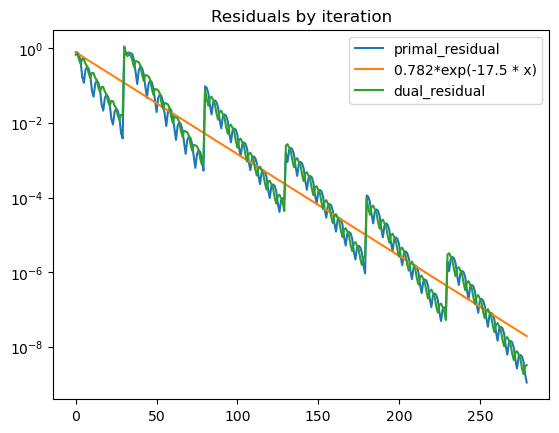

Restart at iteration 100 t= 100
Restart at iteration 200 t= 100
Termination Criteria reached for last iterate at iteration 300
final primal_stepsize 0.22368655324750777 final dual_stepsize 0.22368655324750777


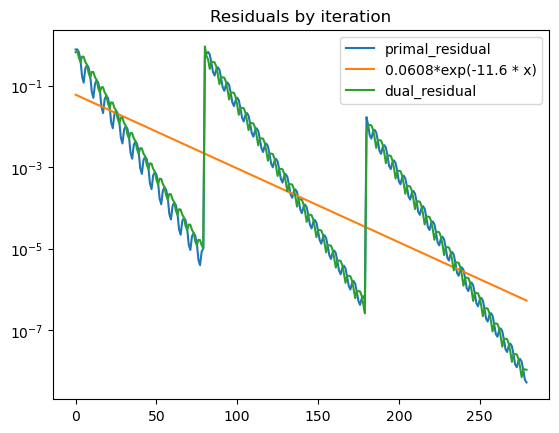

Termination Criteria reached for last iterate at iteration 200
final primal_stepsize 0.22368655324750777 final dual_stepsize 0.22368655324750777


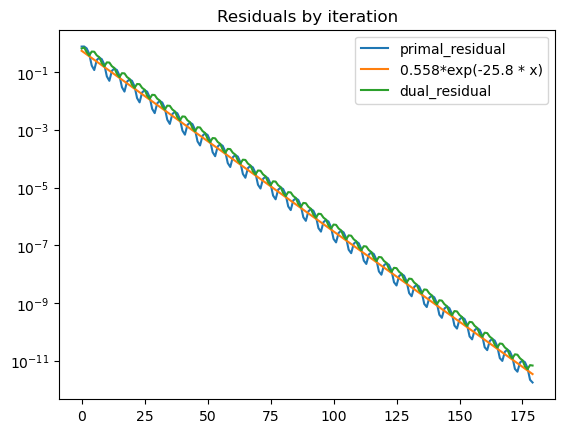

Termination Criteria reached for last iterate at iteration 200
final primal_stepsize 0.22368655324750777 final dual_stepsize 0.22368655324750777


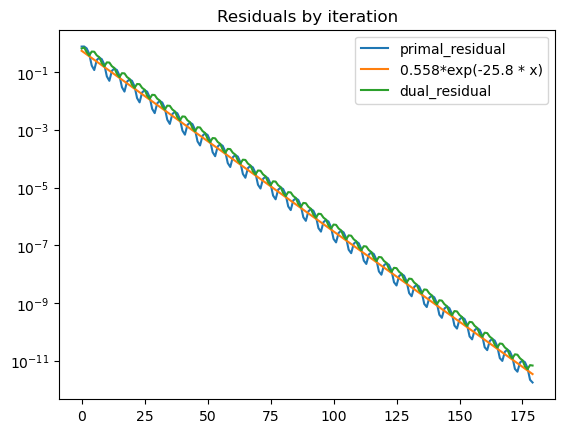

Termination Criteria reached for last iterate at iteration 200
final primal_stepsize 0.22368655324750775 final dual_stepsize 0.22368655324750775


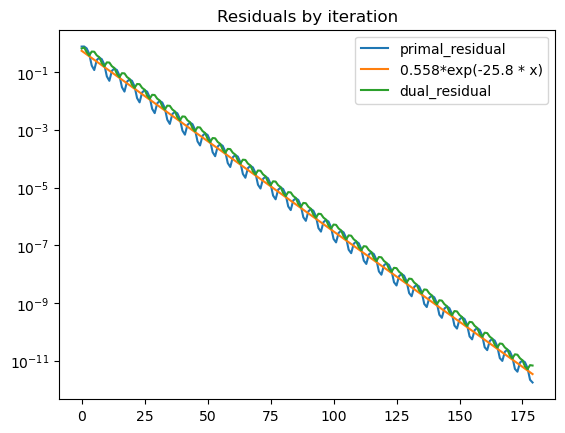

Termination Criteria reached for last iterate at iteration 200
final primal_stepsize 0.22368655324750775 final dual_stepsize 0.22368655324750775


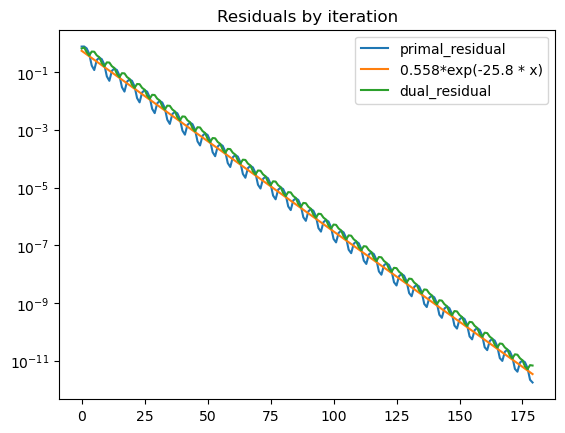

Termination Criteria reached for last iterate at iteration 200
final primal_stepsize 0.22368655324750777 final dual_stepsize 0.22368655324750777


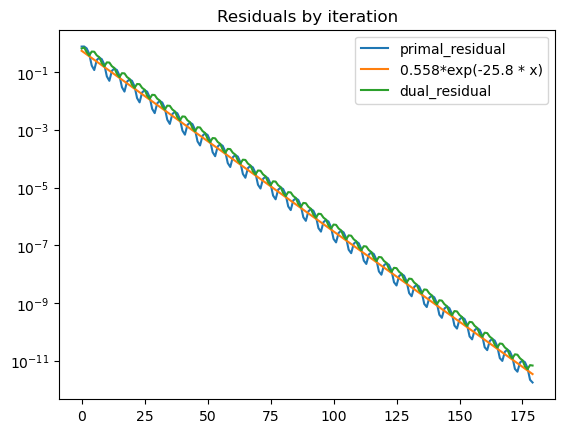

In [19]:
z0=np.zeros((dim+m1+m2,1))
break_val=100000
results=dict()
for restart in [50,100,500,1000,1500,3000,5000]:
    x,y,list_min,k,list_last,list_average,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u,
                            tol=10**-8,break_val=break_val,verbose=False,s='max',termination='other',
                            restart=restart,adaptative=False,n_before_print=100,beta=1/5)
    results[restart]=k

In [20]:
temp=pd.DataFrame(results.values(),results.keys()).reset_index().rename({'index':'restart_length',0:'num_iter'},axis=1)
display(temp)

restart_length  num_iter
0              50       300
1             100       300
2             500       200
3            1000       200
4            1500       200
5            3000       200
6            5000       200

Termination Criteria reached for last iterate at iteration 100
final primal_stepsize 0.22368655324750775 final dual_stepsize 0.22368655324750775


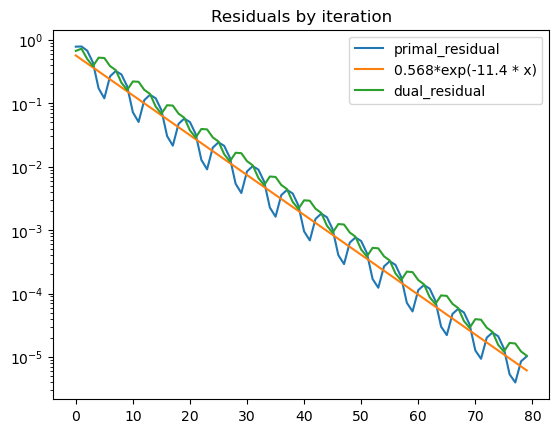

In [21]:
#PDHG
z0=np.zeros((dim+m1+m2,1))
break_val=100000
x1,y1,t1,list_last1,list_average1,list_NDG,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, 
                   tol=10**-4,break_val=break_val, verbose=False,s='max',termination='other',restart=False,
                   adaptative=False,n_before_print=100,beta=0.7)

Termination Criteria reached for last iterate at iteration 200
final primal_stepsize 0.1251320060166808 final dual_stepsize 0.39986311813046505


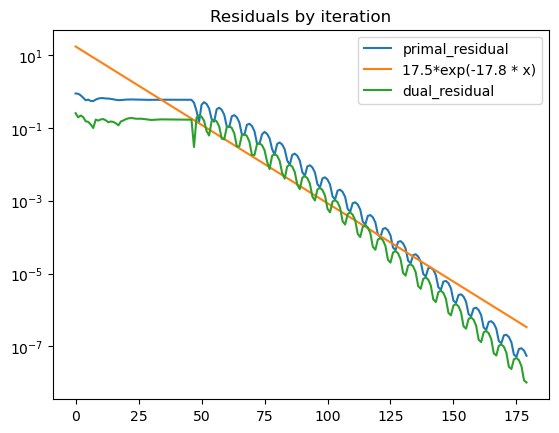

In [22]:
#Adaptative PDHG
x1,y1,t1,list_last1,list_average1,list_NDG,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, 
                   tol=10**-4,break_val=break_val, verbose=False,s='max',termination='other',
                   restart=False,adaptative=True,n_before_print=100,beta=0.7)

Termination Criteria reached for last iterate at iteration 2000
final primal_stepsize 229.05503052544793 final dual_stepsize 0.00021844389965576928
Termination Criteria reached for last iterate at iteration 1000
final primal_stepsize 57.26375763136198 final dual_stepsize 0.0008737755986230771
Termination Criteria reached for last iterate at iteration 1000
final primal_stepsize 14.315939407840498 final dual_stepsize 0.003495102394492309
Termination Criteria reached for last iterate at iteration 1000
final primal_stepsize 3.5789848519601244 final dual_stepsize 0.013980409577969236
Termination Criteria reached for last iterate at iteration 1000
final primal_stepsize 0.894746212990031 final dual_stepsize 0.05592163831187694
Termination Criteria reached for last iterate at iteration 1000
final primal_stepsize 0.22368655324750777 final dual_stepsize 0.22368655324750777
Termination Criteria reached for last iterate at iteration 1000
final primal_stepsize 0.055921638311876944 final dual_stepsi

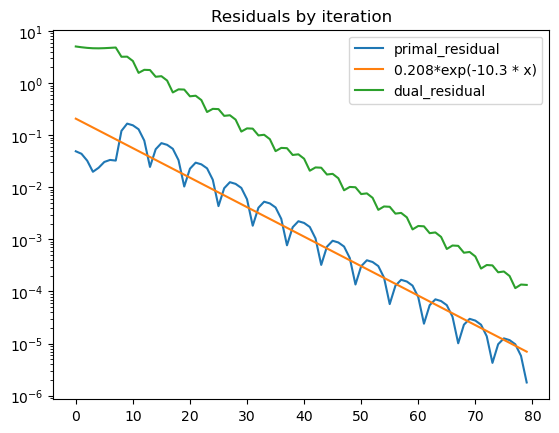

Termination Criteria reached for last iterate at iteration 100
final primal_stepsize 3.5789848519601244 final dual_stepsize 0.013980409577969236


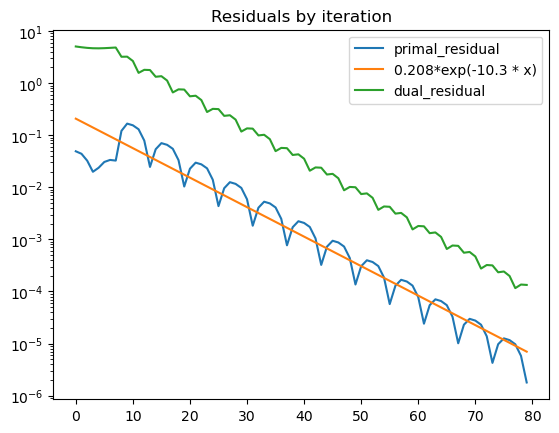

In [23]:
#best w
z0=np.zeros((dim+m1+m2,1))
break_val=5000
results=dict()
for w in [4**i for i in range(-5,6)]:
    x1,y1,t1,list_last1,list_average1,list_NDG,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, 
               A=A, b=b,h=h, l=l, u=u, tol=10**-4,break_val=break_val,verbose=False,s='max',termination='other',
               restart=False,adaptative=False,n_before_print=1000,beta=0.7,w=w,no_verbose=True)
    results[w]=kkt_error
    
break_val=100000
w=min(results, key=results.get)
x1,y1,t1,list_last1,list_average1,list_NDG,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, 
                       A=A, b=b,h=h, l=l, u=u, tol=10**-4,break_val=break_val,verbose=False,
                       s='max',termination='other',restart=False,adaptative=False,n_before_print=100,beta=0.7,w=w)


break_val=100000
x1,y1,t1,list_last1,list_average1,list_NDG,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, 
                    tol=10**-4,break_val=break_val,verbose=False,s='max',termination='other',
                    restart=1000,adaptative=False,n_before_print=100,beta=0.7,w=w)

Termination Criteria reached for last iterate at iteration 100
final primal_stepsize 0.22368655324750775 final dual_stepsize 0.22368655324750775


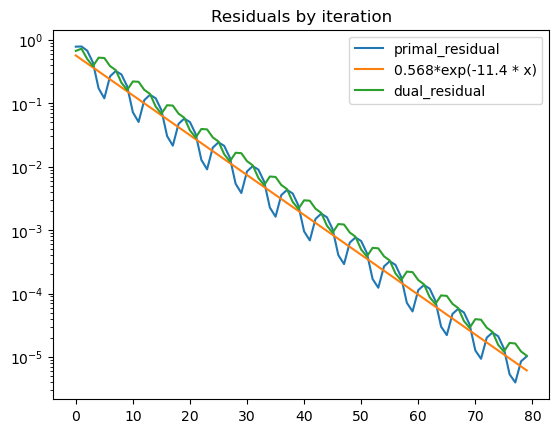

In [25]:
#fixed restart
z0=np.zeros((dim+m1+m2,1))
break_val=100000
x,y,list_min,k,list_last,list_average,kkt_error=AdaptativeRestartPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-4,
                                    break_val=break_val,verbose=False,s='max',termination='other',restart=1000,
                                    adaptative=False,n_before_print=100,beta=0.8,adaptative_restart=False)

Restart at iteration 2 t= 2
Termination Criteria reached at iteration 100


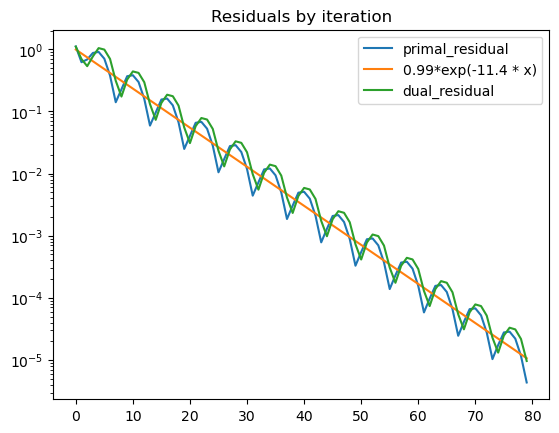

In [26]:
#adptive restart
z0=np.zeros((dim+m1+m2,1))
break_val=100000
x3,y3,k=RestartedPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-4,
                        break_val=break_val, tau0=1,verbose=False,n_before_print=100,min_restart=100,w=None)

Restart at iteration 2 t= 2
iteration 1000
Normalised Duality Gap:  0.0
kkt error:  1.7763568394002505e-15
Residuals:  0.0 0.0
Termination Criteria reached at iteration 1000


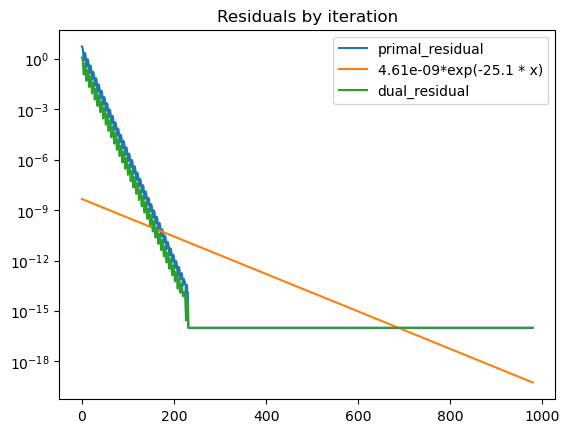

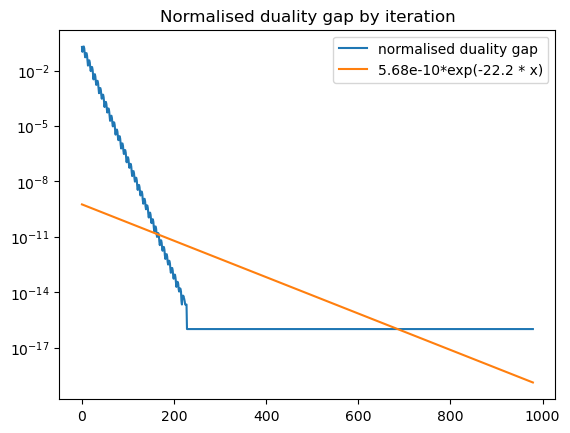

In [39]:
#pdlp
z0=np.zeros((dim+m1+m2,1))
break_val=100000
x,y,k=PDLP(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-4,
                                    break_val=break_val, tau0=1,verbose=False,n_before_print=1000,min_restart=1000)

# Cross Validation

Restart at iteration 4 t= 4
Restart at iteration 8 t= 4
Restart at iteration 12 t= 4
Restart at iteration 16 t= 4
Restart at iteration 20 t= 4
Restart at iteration 24 t= 4
Restart at iteration 28 t= 4
Restart at iteration 32 t= 4
Restart at iteration 36 t= 4
Restart at iteration 40 t= 4
Restart at iteration 44 t= 4
Restart at iteration 48 t= 4
Restart at iteration 52 t= 4
Restart at iteration 56 t= 4
Restart at iteration 60 t= 4
Restart at iteration 64 t= 4
Restart at iteration 68 t= 4
Restart at iteration 72 t= 4
Restart at iteration 76 t= 4
Restart at iteration 80 t= 4
Restart at iteration 84 t= 4
Restart at iteration 88 t= 4
Restart at iteration 92 t= 4
Restart at iteration 96 t= 4
Restart at iteration 100 t= 4
Restart at iteration 104 t= 4
Restart at iteration 108 t= 4
Restart at iteration 112 t= 4
Restart at iteration 116 t= 4
Restart at iteration 120 t= 4
Restart at iteration 124 t= 4
Restart at iteration 128 t= 4
Restart at iteration 132 t= 4
Restart at iteration 136 t= 4
Restar

Restart at iteration 2100 t= 4
Restart at iteration 2104 t= 4
Restart at iteration 2108 t= 4
Restart at iteration 2112 t= 4
Restart at iteration 2116 t= 4
Restart at iteration 2120 t= 4
Restart at iteration 2124 t= 4
Restart at iteration 2128 t= 4
Restart at iteration 2132 t= 4
Restart at iteration 2136 t= 4
Restart at iteration 2140 t= 4
Restart at iteration 2144 t= 4
Restart at iteration 2148 t= 4
Restart at iteration 2152 t= 4
Restart at iteration 2156 t= 4
Restart at iteration 2160 t= 4
Restart at iteration 2164 t= 4
Restart at iteration 2168 t= 4
Restart at iteration 2172 t= 4
Restart at iteration 2176 t= 4
Restart at iteration 2180 t= 4
Restart at iteration 2184 t= 4
Restart at iteration 2188 t= 4
Restart at iteration 2192 t= 4
Restart at iteration 2196 t= 4
Restart at iteration 2200 t= 4
Restart at iteration 2204 t= 4
Restart at iteration 2208 t= 4
Restart at iteration 2212 t= 4
Restart at iteration 2216 t= 4
Restart at iteration 2220 t= 4
Restart at iteration 2224 t= 4
Restart 

Restart at iteration 3200 t= 4
Restart at iteration 3204 t= 4
Restart at iteration 3208 t= 4
Restart at iteration 3212 t= 4
Restart at iteration 3216 t= 4
Restart at iteration 3220 t= 4
Restart at iteration 3224 t= 4
Restart at iteration 3228 t= 4
Restart at iteration 3232 t= 4
Restart at iteration 3236 t= 4
Restart at iteration 3240 t= 4
Restart at iteration 3244 t= 4
Restart at iteration 3248 t= 4
Restart at iteration 3252 t= 4
Restart at iteration 3256 t= 4
Restart at iteration 3260 t= 4
Restart at iteration 3264 t= 4
Restart at iteration 3268 t= 4
Restart at iteration 3272 t= 4
Restart at iteration 3276 t= 4
Restart at iteration 3280 t= 4
Restart at iteration 3284 t= 4
Restart at iteration 3288 t= 4
Restart at iteration 3292 t= 4
Restart at iteration 3296 t= 4
Restart at iteration 3300 t= 4
Restart at iteration 3304 t= 4
Restart at iteration 3308 t= 4
Restart at iteration 3312 t= 4
Restart at iteration 3316 t= 4
Restart at iteration 3320 t= 4
Restart at iteration 3324 t= 4
Restart 

Restart at iteration 4300 t= 4
Restart at iteration 4304 t= 4
Restart at iteration 4308 t= 4
Restart at iteration 4312 t= 4
Restart at iteration 4316 t= 4
Restart at iteration 4320 t= 4
Restart at iteration 4324 t= 4
Restart at iteration 4328 t= 4
Restart at iteration 4332 t= 4
Restart at iteration 4336 t= 4
Restart at iteration 4340 t= 4
Restart at iteration 4344 t= 4
Restart at iteration 4348 t= 4
Restart at iteration 4352 t= 4
Restart at iteration 4356 t= 4
Restart at iteration 4360 t= 4
Restart at iteration 4364 t= 4
Restart at iteration 4368 t= 4
Restart at iteration 4372 t= 4
Restart at iteration 4376 t= 4
Restart at iteration 4380 t= 4
Restart at iteration 4384 t= 4
Restart at iteration 4388 t= 4
Restart at iteration 4392 t= 4
Restart at iteration 4396 t= 4
Restart at iteration 4400 t= 4
Restart at iteration 4404 t= 4
Restart at iteration 4408 t= 4
Restart at iteration 4412 t= 4
Restart at iteration 4416 t= 4
Restart at iteration 4420 t= 4
Restart at iteration 4424 t= 4
Restart 

Restart at iteration 6500 t= 4
Restart at iteration 6504 t= 4
Restart at iteration 6508 t= 4
Restart at iteration 6512 t= 4
Restart at iteration 6516 t= 4
Restart at iteration 6520 t= 4
Restart at iteration 6524 t= 4
Restart at iteration 6528 t= 4
Restart at iteration 6532 t= 4
Restart at iteration 6536 t= 4
Restart at iteration 6540 t= 4
Restart at iteration 6544 t= 4
Restart at iteration 6548 t= 4
Restart at iteration 6552 t= 4
Restart at iteration 6556 t= 4
Restart at iteration 6560 t= 4
Restart at iteration 6564 t= 4
Restart at iteration 6568 t= 4
Restart at iteration 6572 t= 4
Restart at iteration 6576 t= 4
Restart at iteration 6580 t= 4
Restart at iteration 6584 t= 4
Restart at iteration 6588 t= 4
Restart at iteration 6592 t= 4
Restart at iteration 6596 t= 4
Restart at iteration 6600 t= 4
Restart at iteration 6604 t= 4
Restart at iteration 6608 t= 4
Restart at iteration 6612 t= 4
Restart at iteration 6616 t= 4
Restart at iteration 6620 t= 4
Restart at iteration 6624 t= 4
Restart 

Restart at iteration 7600 t= 4
Restart at iteration 7604 t= 4
Restart at iteration 7608 t= 4
Restart at iteration 7612 t= 4
Restart at iteration 7616 t= 4
Restart at iteration 7620 t= 4
Restart at iteration 7624 t= 4
Restart at iteration 7628 t= 4
Restart at iteration 7632 t= 4
Restart at iteration 7636 t= 4
Restart at iteration 7640 t= 4
Restart at iteration 7644 t= 4
Restart at iteration 7648 t= 4
Restart at iteration 7652 t= 4
Restart at iteration 7656 t= 4
Restart at iteration 7660 t= 4
Restart at iteration 7664 t= 4
Restart at iteration 7668 t= 4
Restart at iteration 7672 t= 4
Restart at iteration 7676 t= 4
Restart at iteration 7680 t= 4
Restart at iteration 7684 t= 4
Restart at iteration 7688 t= 4
Restart at iteration 7692 t= 4
Restart at iteration 7696 t= 4
Restart at iteration 7700 t= 4
Restart at iteration 7704 t= 4
Restart at iteration 7708 t= 4
Restart at iteration 7712 t= 4
Restart at iteration 7716 t= 4
Restart at iteration 7720 t= 4
Restart at iteration 7724 t= 4
Restart 

Restart at iteration 8700 t= 4
Restart at iteration 8704 t= 4
Restart at iteration 8708 t= 4
Restart at iteration 8712 t= 4
Restart at iteration 8716 t= 4
Restart at iteration 8720 t= 4
Restart at iteration 8724 t= 4
Restart at iteration 8728 t= 4
Restart at iteration 8732 t= 4
Restart at iteration 8736 t= 4
Restart at iteration 8740 t= 4
Restart at iteration 8744 t= 4
Restart at iteration 8748 t= 4
Restart at iteration 8752 t= 4
Restart at iteration 8756 t= 4
Restart at iteration 8760 t= 4
Restart at iteration 8764 t= 4
Restart at iteration 8768 t= 4
Restart at iteration 8772 t= 4
Restart at iteration 8776 t= 4
Restart at iteration 8780 t= 4
Restart at iteration 8784 t= 4
Restart at iteration 8788 t= 4
Restart at iteration 8792 t= 4
Restart at iteration 8796 t= 4
Restart at iteration 8800 t= 4
Restart at iteration 8804 t= 4
Restart at iteration 8808 t= 4
Restart at iteration 8812 t= 4
Restart at iteration 8816 t= 4
Restart at iteration 8820 t= 4
Restart at iteration 8824 t= 4
Restart 

Restart at iteration 9900 t= 4
Restart at iteration 9904 t= 4
Restart at iteration 9908 t= 4
Restart at iteration 9912 t= 4
Restart at iteration 9916 t= 4
Restart at iteration 9920 t= 4
Restart at iteration 9924 t= 4
Restart at iteration 9928 t= 4
Restart at iteration 9932 t= 4
Restart at iteration 9936 t= 4
Restart at iteration 9940 t= 4
Restart at iteration 9944 t= 4
Restart at iteration 9948 t= 4
Restart at iteration 9952 t= 4
Restart at iteration 9956 t= 4
Restart at iteration 9960 t= 4
Restart at iteration 9964 t= 4
Restart at iteration 9968 t= 4
Restart at iteration 9972 t= 4
Restart at iteration 9976 t= 4
Restart at iteration 9980 t= 4
Restart at iteration 9984 t= 4
Restart at iteration 9988 t= 4
Restart at iteration 9992 t= 4
Restart at iteration 9996 t= 4
Restart at iteration 10000 t= 4
Restart at iteration 10004 t= 4
Restart at iteration 10008 t= 4
Restart at iteration 10012 t= 4
Restart at iteration 10016 t= 4
Restart at iteration 10020 t= 4
Restart at iteration 10024 t= 4
R

Restart at iteration 11000 t= 4
Restart at iteration 11004 t= 4
Restart at iteration 11008 t= 4
Restart at iteration 11012 t= 4
Restart at iteration 11016 t= 4
Restart at iteration 11020 t= 4
Restart at iteration 11024 t= 4
Restart at iteration 11028 t= 4
Restart at iteration 11032 t= 4
Restart at iteration 11036 t= 4
Restart at iteration 11040 t= 4
Restart at iteration 11044 t= 4
Restart at iteration 11048 t= 4
Restart at iteration 11052 t= 4
Restart at iteration 11056 t= 4
Restart at iteration 11060 t= 4
Restart at iteration 11064 t= 4
Restart at iteration 11068 t= 4
Restart at iteration 11072 t= 4
Restart at iteration 11076 t= 4
Restart at iteration 11080 t= 4
Restart at iteration 11084 t= 4
Restart at iteration 11088 t= 4
Restart at iteration 11092 t= 4
Restart at iteration 11096 t= 4
Restart at iteration 11100 t= 4
Restart at iteration 11104 t= 4
Restart at iteration 11108 t= 4
Restart at iteration 11112 t= 4
Restart at iteration 11116 t= 4
Restart at iteration 11120 t= 4
Restart 

Restart at iteration 12100 t= 4
Restart at iteration 12104 t= 4
Restart at iteration 12108 t= 4
Restart at iteration 12112 t= 4
Restart at iteration 12116 t= 4
Restart at iteration 12120 t= 4
Restart at iteration 12124 t= 4
Restart at iteration 12128 t= 4
Restart at iteration 12132 t= 4
Restart at iteration 12136 t= 4
Restart at iteration 12140 t= 4
Restart at iteration 12144 t= 4
Restart at iteration 12148 t= 4
Restart at iteration 12152 t= 4
Restart at iteration 12156 t= 4
Restart at iteration 12160 t= 4
Restart at iteration 12164 t= 4
Restart at iteration 12168 t= 4
Restart at iteration 12172 t= 4
Restart at iteration 12176 t= 4
Restart at iteration 12180 t= 4
Restart at iteration 12184 t= 4
Restart at iteration 12188 t= 4
Restart at iteration 12192 t= 4
Restart at iteration 12196 t= 4
Restart at iteration 12200 t= 4
Restart at iteration 12204 t= 4
Restart at iteration 12208 t= 4
Restart at iteration 12212 t= 4
Restart at iteration 12216 t= 4
Restart at iteration 12220 t= 4
Restart 

Restart at iteration 13200 t= 4
Restart at iteration 13204 t= 4
Restart at iteration 13208 t= 4
Restart at iteration 13212 t= 4
Restart at iteration 13216 t= 4
Restart at iteration 13220 t= 4
Restart at iteration 13224 t= 4
Restart at iteration 13228 t= 4
Restart at iteration 13232 t= 4
Restart at iteration 13236 t= 4
Restart at iteration 13240 t= 4
Restart at iteration 13244 t= 4
Restart at iteration 13248 t= 4
Restart at iteration 13252 t= 4
Restart at iteration 13256 t= 4
Restart at iteration 13260 t= 4
Restart at iteration 13264 t= 4
Restart at iteration 13268 t= 4
Restart at iteration 13272 t= 4
Restart at iteration 13276 t= 4
Restart at iteration 13280 t= 4
Restart at iteration 13284 t= 4
Restart at iteration 13288 t= 4
Restart at iteration 13292 t= 4
Restart at iteration 13296 t= 4
Restart at iteration 13300 t= 4
Restart at iteration 13304 t= 4
Restart at iteration 13308 t= 4
Restart at iteration 13312 t= 4
Restart at iteration 13316 t= 4
Restart at iteration 13320 t= 4
Restart 

Restart at iteration 14300 t= 4
Restart at iteration 14304 t= 4
Restart at iteration 14308 t= 4
Restart at iteration 14312 t= 4
Restart at iteration 14316 t= 4
Restart at iteration 14320 t= 4
Restart at iteration 14324 t= 4
Restart at iteration 14328 t= 4
Restart at iteration 14332 t= 4
Restart at iteration 14336 t= 4
Restart at iteration 14340 t= 4
Restart at iteration 14344 t= 4
Restart at iteration 14348 t= 4
Restart at iteration 14352 t= 4
Restart at iteration 14356 t= 4
Restart at iteration 14360 t= 4
Restart at iteration 14364 t= 4
Restart at iteration 14368 t= 4
Restart at iteration 14372 t= 4
Restart at iteration 14376 t= 4
Restart at iteration 14380 t= 4
Restart at iteration 14384 t= 4
Restart at iteration 14388 t= 4
Restart at iteration 14392 t= 4
Restart at iteration 14396 t= 4
Restart at iteration 14400 t= 4
Restart at iteration 14404 t= 4
Restart at iteration 14408 t= 4
Restart at iteration 14412 t= 4
Restart at iteration 14416 t= 4
Restart at iteration 14420 t= 4
Restart 

Restart at iteration 15400 t= 4
Restart at iteration 15404 t= 4
Restart at iteration 15408 t= 4
Restart at iteration 15412 t= 4
Restart at iteration 15416 t= 4
Restart at iteration 15420 t= 4
Restart at iteration 15424 t= 4
Restart at iteration 15428 t= 4
Restart at iteration 15432 t= 4
Restart at iteration 15436 t= 4
Restart at iteration 15440 t= 4
Restart at iteration 15444 t= 4
Restart at iteration 15448 t= 4
Restart at iteration 15452 t= 4
Restart at iteration 15456 t= 4
Restart at iteration 15460 t= 4
Restart at iteration 15464 t= 4
Restart at iteration 15468 t= 4
Restart at iteration 15472 t= 4
Restart at iteration 15476 t= 4
Restart at iteration 15480 t= 4
Restart at iteration 15484 t= 4
Restart at iteration 15488 t= 4
Restart at iteration 15492 t= 4
Restart at iteration 15496 t= 4
Restart at iteration 15500 t= 4
Restart at iteration 15504 t= 4
Restart at iteration 15508 t= 4
Restart at iteration 15512 t= 4
Restart at iteration 15516 t= 4
Restart at iteration 15520 t= 4
Restart 

Restart at iteration 16600 t= 4
Restart at iteration 16604 t= 4
Restart at iteration 16608 t= 4
Restart at iteration 16612 t= 4
Restart at iteration 16616 t= 4
Restart at iteration 16620 t= 4
Restart at iteration 16624 t= 4
Restart at iteration 16628 t= 4
Restart at iteration 16632 t= 4
Restart at iteration 16636 t= 4
Restart at iteration 16640 t= 4
Restart at iteration 16644 t= 4
Restart at iteration 16648 t= 4
Restart at iteration 16652 t= 4
Restart at iteration 16656 t= 4
Restart at iteration 16660 t= 4
Restart at iteration 16664 t= 4
Restart at iteration 16668 t= 4
Restart at iteration 16672 t= 4
Restart at iteration 16676 t= 4
Restart at iteration 16680 t= 4
Restart at iteration 16684 t= 4
Restart at iteration 16688 t= 4
Restart at iteration 16692 t= 4
Restart at iteration 16696 t= 4
Restart at iteration 16700 t= 4
Restart at iteration 16704 t= 4
Restart at iteration 16708 t= 4
Restart at iteration 16712 t= 4
Restart at iteration 16716 t= 4
Restart at iteration 16720 t= 4
Restart 

Restart at iteration 17700 t= 4
Restart at iteration 17704 t= 4
Restart at iteration 17708 t= 4
Restart at iteration 17712 t= 4
Restart at iteration 17716 t= 4
Restart at iteration 17720 t= 4
Restart at iteration 17724 t= 4
Restart at iteration 17728 t= 4
Restart at iteration 17732 t= 4
Restart at iteration 17736 t= 4
Restart at iteration 17740 t= 4
Restart at iteration 17744 t= 4
Restart at iteration 17748 t= 4
Restart at iteration 17752 t= 4
Restart at iteration 17756 t= 4
Restart at iteration 17760 t= 4
Restart at iteration 17764 t= 4
Restart at iteration 17768 t= 4
Restart at iteration 17772 t= 4
Restart at iteration 17776 t= 4
Restart at iteration 17780 t= 4
Restart at iteration 17784 t= 4
Restart at iteration 17788 t= 4
Restart at iteration 17792 t= 4
Restart at iteration 17796 t= 4
Restart at iteration 17800 t= 4
Restart at iteration 17804 t= 4
Restart at iteration 17808 t= 4
Restart at iteration 17812 t= 4
Restart at iteration 17816 t= 4
Restart at iteration 17820 t= 4
Restart 

Restart at iteration 18788 t= 4
Restart at iteration 18792 t= 4
Restart at iteration 18796 t= 4
Restart at iteration 18800 t= 4
Restart at iteration 18804 t= 4
Restart at iteration 18808 t= 4
Restart at iteration 18812 t= 4
Restart at iteration 18816 t= 4
Restart at iteration 18820 t= 4
Restart at iteration 18824 t= 4
Restart at iteration 18828 t= 4
Restart at iteration 18832 t= 4
Restart at iteration 18836 t= 4
Restart at iteration 18840 t= 4
Restart at iteration 18844 t= 4
Restart at iteration 18848 t= 4
Restart at iteration 18852 t= 4
Restart at iteration 18856 t= 4
Restart at iteration 18860 t= 4
Restart at iteration 18864 t= 4
Restart at iteration 18868 t= 4
Restart at iteration 18872 t= 4
Restart at iteration 18876 t= 4
Restart at iteration 18880 t= 4
Restart at iteration 18884 t= 4
Restart at iteration 18888 t= 4
Restart at iteration 18892 t= 4
Restart at iteration 18896 t= 4
Restart at iteration 18900 t= 4
Restart at iteration 18904 t= 4
Restart at iteration 18908 t= 4
Restart 

Restart at iteration 20964 t= 4
Restart at iteration 20968 t= 4
Restart at iteration 20972 t= 4
Restart at iteration 20976 t= 4
Restart at iteration 20980 t= 4
Restart at iteration 20984 t= 4
Restart at iteration 20988 t= 4
Restart at iteration 20992 t= 4
Restart at iteration 20996 t= 4
Restart at iteration 21000 t= 4
Restart at iteration 21004 t= 4
Restart at iteration 21008 t= 4
Restart at iteration 21012 t= 4
Restart at iteration 21016 t= 4
Restart at iteration 21020 t= 4
Restart at iteration 21024 t= 4
Restart at iteration 21028 t= 4
Restart at iteration 21032 t= 4
Restart at iteration 21036 t= 4
Restart at iteration 21040 t= 4
Restart at iteration 21044 t= 4
Restart at iteration 21048 t= 4
Restart at iteration 21052 t= 4
Restart at iteration 21056 t= 4
Restart at iteration 21060 t= 4
Restart at iteration 21064 t= 4
Restart at iteration 21068 t= 4
Restart at iteration 21072 t= 4
Restart at iteration 21076 t= 4
Restart at iteration 21080 t= 4
Restart at iteration 21084 t= 4
Restart 

Restart at iteration 22100 t= 4
Restart at iteration 22104 t= 4
Restart at iteration 22108 t= 4
Restart at iteration 22112 t= 4
Restart at iteration 22116 t= 4
Restart at iteration 22120 t= 4
Restart at iteration 22124 t= 4
Restart at iteration 22128 t= 4
Restart at iteration 22132 t= 4
Restart at iteration 22136 t= 4
Restart at iteration 22140 t= 4
Restart at iteration 22144 t= 4
Restart at iteration 22148 t= 4
Restart at iteration 22152 t= 4
Restart at iteration 22156 t= 4
Restart at iteration 22160 t= 4
Restart at iteration 22164 t= 4
Restart at iteration 22168 t= 4
Restart at iteration 22172 t= 4
Restart at iteration 22176 t= 4
Restart at iteration 22180 t= 4
Restart at iteration 22184 t= 4
Restart at iteration 22188 t= 4
Restart at iteration 22192 t= 4
Restart at iteration 22196 t= 4
Restart at iteration 22200 t= 4
Restart at iteration 22204 t= 4
Restart at iteration 22208 t= 4
Restart at iteration 22212 t= 4
Restart at iteration 22216 t= 4
Restart at iteration 22220 t= 4
Restart 

Restart at iteration 23200 t= 4
Restart at iteration 23204 t= 4
Restart at iteration 23208 t= 4
Restart at iteration 23212 t= 4
Restart at iteration 23216 t= 4
Restart at iteration 23220 t= 4
Restart at iteration 23224 t= 4
Restart at iteration 23228 t= 4
Restart at iteration 23232 t= 4
Restart at iteration 23236 t= 4
Restart at iteration 23240 t= 4
Restart at iteration 23244 t= 4
Restart at iteration 23248 t= 4
Restart at iteration 23252 t= 4
Restart at iteration 23256 t= 4
Restart at iteration 23260 t= 4
Restart at iteration 23264 t= 4
Restart at iteration 23268 t= 4
Restart at iteration 23272 t= 4
Restart at iteration 23276 t= 4
Restart at iteration 23280 t= 4
Restart at iteration 23284 t= 4
Restart at iteration 23288 t= 4
Restart at iteration 23292 t= 4
Restart at iteration 23296 t= 4
Restart at iteration 23300 t= 4
Restart at iteration 23304 t= 4
Restart at iteration 23308 t= 4
Restart at iteration 23312 t= 4
Restart at iteration 23316 t= 4
Restart at iteration 23320 t= 4
Restart 

Restart at iteration 24400 t= 4
Restart at iteration 24404 t= 4
Restart at iteration 24408 t= 4
Restart at iteration 24412 t= 4
Restart at iteration 24416 t= 4
Restart at iteration 24420 t= 4
Restart at iteration 24424 t= 4
Restart at iteration 24428 t= 4
Restart at iteration 24432 t= 4
Restart at iteration 24436 t= 4
Restart at iteration 24440 t= 4
Restart at iteration 24444 t= 4
Restart at iteration 24448 t= 4
Restart at iteration 24452 t= 4
Restart at iteration 24456 t= 4
Restart at iteration 24460 t= 4
Restart at iteration 24464 t= 4
Restart at iteration 24468 t= 4
Restart at iteration 24472 t= 4
Restart at iteration 24476 t= 4
Restart at iteration 24480 t= 4
Restart at iteration 24484 t= 4
Restart at iteration 24488 t= 4
Restart at iteration 24492 t= 4
Restart at iteration 24496 t= 4
Restart at iteration 24500 t= 4
Restart at iteration 24504 t= 4
Restart at iteration 24508 t= 4
Restart at iteration 24512 t= 4
Restart at iteration 24516 t= 4
Restart at iteration 24520 t= 4
Restart 

Restart at iteration 25592 t= 4
Restart at iteration 25596 t= 4
Restart at iteration 25600 t= 4
Restart at iteration 25604 t= 4
Restart at iteration 25608 t= 4
Restart at iteration 25612 t= 4
Restart at iteration 25616 t= 4
Restart at iteration 25620 t= 4
Restart at iteration 25624 t= 4
Restart at iteration 25628 t= 4
Restart at iteration 25632 t= 4
Restart at iteration 25636 t= 4
Restart at iteration 25640 t= 4
Restart at iteration 25644 t= 4
Restart at iteration 25648 t= 4
Restart at iteration 25652 t= 4
Restart at iteration 25656 t= 4
Restart at iteration 25660 t= 4
Restart at iteration 25664 t= 4
Restart at iteration 25668 t= 4
Restart at iteration 25672 t= 4
Restart at iteration 25676 t= 4
Restart at iteration 25680 t= 4
Restart at iteration 25684 t= 4
Restart at iteration 25688 t= 4
Restart at iteration 25692 t= 4
Restart at iteration 25696 t= 4
Restart at iteration 25700 t= 4
Restart at iteration 25704 t= 4
Restart at iteration 25708 t= 4
Restart at iteration 25712 t= 4
Restart 

Restart at iteration 26700 t= 4
Restart at iteration 26704 t= 4
Restart at iteration 26708 t= 4
Restart at iteration 26712 t= 4
Restart at iteration 26716 t= 4
Restart at iteration 26720 t= 4
Restart at iteration 26724 t= 4
Restart at iteration 26728 t= 4
Restart at iteration 26732 t= 4
Restart at iteration 26736 t= 4
Restart at iteration 26740 t= 4
Restart at iteration 26744 t= 4
Restart at iteration 26748 t= 4
Restart at iteration 26752 t= 4
Restart at iteration 26756 t= 4
Restart at iteration 26760 t= 4
Restart at iteration 26764 t= 4
Restart at iteration 26768 t= 4
Restart at iteration 26772 t= 4
Restart at iteration 26776 t= 4
Restart at iteration 26780 t= 4
Restart at iteration 26784 t= 4
Restart at iteration 26788 t= 4
Restart at iteration 26792 t= 4
Restart at iteration 26796 t= 4
Restart at iteration 26800 t= 4
Restart at iteration 26804 t= 4
Restart at iteration 26808 t= 4
Restart at iteration 26812 t= 4
Restart at iteration 26816 t= 4
Restart at iteration 26820 t= 4
Restart 

Restart at iteration 27800 t= 4
Restart at iteration 27804 t= 4
Restart at iteration 27808 t= 4
Restart at iteration 27812 t= 4
Restart at iteration 27816 t= 4
Restart at iteration 27820 t= 4
Restart at iteration 27824 t= 4
Restart at iteration 27828 t= 4
Restart at iteration 27832 t= 4
Restart at iteration 27836 t= 4
Restart at iteration 27840 t= 4
Restart at iteration 27844 t= 4
Restart at iteration 27848 t= 4
Restart at iteration 27852 t= 4
Restart at iteration 27856 t= 4
Restart at iteration 27860 t= 4
Restart at iteration 27864 t= 4
Restart at iteration 27868 t= 4
Restart at iteration 27872 t= 4
Restart at iteration 27876 t= 4
Restart at iteration 27880 t= 4
Restart at iteration 27884 t= 4
Restart at iteration 27888 t= 4
Restart at iteration 27892 t= 4
Restart at iteration 27896 t= 4
Restart at iteration 27900 t= 4
Restart at iteration 27904 t= 4
Restart at iteration 27908 t= 4
Restart at iteration 27912 t= 4
Restart at iteration 27916 t= 4
Restart at iteration 27920 t= 4
Restart 

Restart at iteration 28852 t= 4
Restart at iteration 28856 t= 4
Restart at iteration 28860 t= 4
Restart at iteration 28864 t= 4
Restart at iteration 28868 t= 4
Restart at iteration 28872 t= 4
Restart at iteration 28876 t= 4
Restart at iteration 28880 t= 4
Restart at iteration 28884 t= 4
Restart at iteration 28888 t= 4
Restart at iteration 28892 t= 4
Restart at iteration 28896 t= 4
Restart at iteration 28900 t= 4
Restart at iteration 28904 t= 4
Restart at iteration 28908 t= 4
Restart at iteration 28912 t= 4
Restart at iteration 28916 t= 4
Restart at iteration 28920 t= 4
Restart at iteration 28924 t= 4
Restart at iteration 28928 t= 4
Restart at iteration 28932 t= 4
Restart at iteration 28936 t= 4
Restart at iteration 28940 t= 4
Restart at iteration 28944 t= 4
Restart at iteration 28948 t= 4
Restart at iteration 28952 t= 4
Restart at iteration 28956 t= 4
Restart at iteration 28960 t= 4
Restart at iteration 28964 t= 4
Restart at iteration 28968 t= 4
Restart at iteration 28972 t= 4
Restart 

Restart at iteration 29900 t= 4
Restart at iteration 29904 t= 4
Restart at iteration 29908 t= 4
Restart at iteration 29912 t= 4
Restart at iteration 29916 t= 4
Restart at iteration 29920 t= 4
Restart at iteration 29924 t= 4
Restart at iteration 29928 t= 4
Restart at iteration 29932 t= 4
Restart at iteration 29936 t= 4
Restart at iteration 29940 t= 4
Restart at iteration 29944 t= 4
Restart at iteration 29948 t= 4
Restart at iteration 29952 t= 4
Restart at iteration 29956 t= 4
Restart at iteration 29960 t= 4
Restart at iteration 29964 t= 4
Restart at iteration 29968 t= 4
Restart at iteration 29972 t= 4
Restart at iteration 29976 t= 4
Restart at iteration 29980 t= 4
Restart at iteration 29984 t= 4
Restart at iteration 29988 t= 4
Restart at iteration 29992 t= 4
Restart at iteration 29996 t= 4
Restart at iteration 30000 t= 4
Restart at iteration 30004 t= 4
Restart at iteration 30008 t= 4
Restart at iteration 30012 t= 4
Restart at iteration 30016 t= 4
Restart at iteration 30020 t= 4
Restart 

Restart at iteration 31000 t= 4
Restart at iteration 31004 t= 4
Restart at iteration 31008 t= 4
Restart at iteration 31012 t= 4
Restart at iteration 31016 t= 4
Restart at iteration 31020 t= 4
Restart at iteration 31024 t= 4
Restart at iteration 31028 t= 4
Restart at iteration 31032 t= 4
Restart at iteration 31036 t= 4
Restart at iteration 31040 t= 4
Restart at iteration 31044 t= 4
Restart at iteration 31048 t= 4
Restart at iteration 31052 t= 4
Restart at iteration 31056 t= 4
Restart at iteration 31060 t= 4
Restart at iteration 31064 t= 4
Restart at iteration 31068 t= 4
Restart at iteration 31072 t= 4
Restart at iteration 31076 t= 4
Restart at iteration 31080 t= 4
Restart at iteration 31084 t= 4
Restart at iteration 31088 t= 4
Restart at iteration 31092 t= 4
Restart at iteration 31096 t= 4
Restart at iteration 31100 t= 4
Restart at iteration 31104 t= 4
Restart at iteration 31108 t= 4
Restart at iteration 31112 t= 4
Restart at iteration 31116 t= 4
Restart at iteration 31120 t= 4
Restart 

Restart at iteration 32080 t= 4
Restart at iteration 32084 t= 4
Restart at iteration 32088 t= 4
Restart at iteration 32092 t= 4
Restart at iteration 32096 t= 4
Restart at iteration 32100 t= 4
Restart at iteration 32104 t= 4
Restart at iteration 32108 t= 4
Restart at iteration 32112 t= 4
Restart at iteration 32116 t= 4
Restart at iteration 32120 t= 4
Restart at iteration 32124 t= 4
Restart at iteration 32128 t= 4
Restart at iteration 32132 t= 4
Restart at iteration 32136 t= 4
Restart at iteration 32140 t= 4
Restart at iteration 32144 t= 4
Restart at iteration 32148 t= 4
Restart at iteration 32152 t= 4
Restart at iteration 32156 t= 4
Restart at iteration 32160 t= 4
Restart at iteration 32164 t= 4
Restart at iteration 32168 t= 4
Restart at iteration 32172 t= 4
Restart at iteration 32176 t= 4
Restart at iteration 32180 t= 4
Restart at iteration 32184 t= 4
Restart at iteration 32188 t= 4
Restart at iteration 32192 t= 4
Restart at iteration 32196 t= 4
Restart at iteration 32200 t= 4
Restart 

Restart at iteration 33200 t= 4
Restart at iteration 33204 t= 4
Restart at iteration 33208 t= 4
Restart at iteration 33212 t= 4
Restart at iteration 33216 t= 4
Restart at iteration 33220 t= 4
Restart at iteration 33224 t= 4
Restart at iteration 33228 t= 4
Restart at iteration 33232 t= 4
Restart at iteration 33236 t= 4
Restart at iteration 33240 t= 4
Restart at iteration 33244 t= 4
Restart at iteration 33248 t= 4
Restart at iteration 33252 t= 4
Restart at iteration 33256 t= 4
Restart at iteration 33260 t= 4
Restart at iteration 33264 t= 4
Restart at iteration 33268 t= 4
Restart at iteration 33272 t= 4
Restart at iteration 33276 t= 4
Restart at iteration 33280 t= 4
Restart at iteration 33284 t= 4
Restart at iteration 33288 t= 4
Restart at iteration 33292 t= 4
Restart at iteration 33296 t= 4
Restart at iteration 33300 t= 4
Restart at iteration 33304 t= 4
Restart at iteration 33308 t= 4
Restart at iteration 33312 t= 4
Restart at iteration 33316 t= 4
Restart at iteration 33320 t= 4
Restart 

Restart at iteration 34400 t= 4
Restart at iteration 34404 t= 4
Restart at iteration 34408 t= 4
Restart at iteration 34412 t= 4
Restart at iteration 34416 t= 4
Restart at iteration 34420 t= 4
Restart at iteration 34424 t= 4
Restart at iteration 34428 t= 4
Restart at iteration 34432 t= 4
Restart at iteration 34436 t= 4
Restart at iteration 34440 t= 4
Restart at iteration 34444 t= 4
Restart at iteration 34448 t= 4
Restart at iteration 34452 t= 4
Restart at iteration 34456 t= 4
Restart at iteration 34460 t= 4
Restart at iteration 34464 t= 4
Restart at iteration 34468 t= 4
Restart at iteration 34472 t= 4
Restart at iteration 34476 t= 4
Restart at iteration 34480 t= 4
Restart at iteration 34484 t= 4
Restart at iteration 34488 t= 4
Restart at iteration 34492 t= 4
Restart at iteration 34496 t= 4
Restart at iteration 34500 t= 4
Restart at iteration 34504 t= 4
Restart at iteration 34508 t= 4
Restart at iteration 34512 t= 4
Restart at iteration 34516 t= 4
Restart at iteration 34520 t= 4
Restart 

Restart at iteration 35700 t= 4
Restart at iteration 35704 t= 4
Restart at iteration 35708 t= 4
Restart at iteration 35712 t= 4
Restart at iteration 35716 t= 4
Restart at iteration 35720 t= 4
Restart at iteration 35724 t= 4
Restart at iteration 35728 t= 4
Restart at iteration 35732 t= 4
Restart at iteration 35736 t= 4
Restart at iteration 35740 t= 4
Restart at iteration 35744 t= 4
Restart at iteration 35748 t= 4
Restart at iteration 35752 t= 4
Restart at iteration 35756 t= 4
Restart at iteration 35760 t= 4
Restart at iteration 35764 t= 4
Restart at iteration 35768 t= 4
Restart at iteration 35772 t= 4
Restart at iteration 35776 t= 4
Restart at iteration 35780 t= 4
Restart at iteration 35784 t= 4
Restart at iteration 35788 t= 4
Restart at iteration 35792 t= 4
Restart at iteration 35796 t= 4
Restart at iteration 35800 t= 4
Restart at iteration 35804 t= 4
Restart at iteration 35808 t= 4
Restart at iteration 35812 t= 4
Restart at iteration 35816 t= 4
Restart at iteration 35820 t= 4
Restart 

Restart at iteration 36900 t= 4
Restart at iteration 36904 t= 4
Restart at iteration 36908 t= 4
Restart at iteration 36912 t= 4
Restart at iteration 36916 t= 4
Restart at iteration 36920 t= 4
Restart at iteration 36924 t= 4
Restart at iteration 36928 t= 4
Restart at iteration 36932 t= 4
Restart at iteration 36936 t= 4
Restart at iteration 36940 t= 4
Restart at iteration 36944 t= 4
Restart at iteration 36948 t= 4
Restart at iteration 36952 t= 4
Restart at iteration 36956 t= 4
Restart at iteration 36960 t= 4
Restart at iteration 36964 t= 4
Restart at iteration 36968 t= 4
Restart at iteration 36972 t= 4
Restart at iteration 36976 t= 4
Restart at iteration 36980 t= 4
Restart at iteration 36984 t= 4
Restart at iteration 36988 t= 4
Restart at iteration 36992 t= 4
Restart at iteration 36996 t= 4
Restart at iteration 37000 t= 4
Restart at iteration 37004 t= 4
Restart at iteration 37008 t= 4
Restart at iteration 37012 t= 4
Restart at iteration 37016 t= 4
Restart at iteration 37020 t= 4
Restart 

Restart at iteration 38056 t= 4
Restart at iteration 38060 t= 4
Restart at iteration 38064 t= 4
Restart at iteration 38068 t= 4
Restart at iteration 38072 t= 4
Restart at iteration 38076 t= 4
Restart at iteration 38080 t= 4
Restart at iteration 38084 t= 4
Restart at iteration 38088 t= 4
Restart at iteration 38092 t= 4
Restart at iteration 38096 t= 4
Restart at iteration 38100 t= 4
Restart at iteration 38104 t= 4
Restart at iteration 38108 t= 4
Restart at iteration 38112 t= 4
Restart at iteration 38116 t= 4
Restart at iteration 38120 t= 4
Restart at iteration 38124 t= 4
Restart at iteration 38128 t= 4
Restart at iteration 38132 t= 4
Restart at iteration 38136 t= 4
Restart at iteration 38140 t= 4
Restart at iteration 38144 t= 4
Restart at iteration 38148 t= 4
Restart at iteration 38152 t= 4
Restart at iteration 38156 t= 4
Restart at iteration 38160 t= 4
Restart at iteration 38164 t= 4
Restart at iteration 38168 t= 4
Restart at iteration 38172 t= 4
Restart at iteration 38176 t= 4
Restart 

Restart at iteration 39200 t= 4
Restart at iteration 39204 t= 4
Restart at iteration 39208 t= 4
Restart at iteration 39212 t= 4
Restart at iteration 39216 t= 4
Restart at iteration 39220 t= 4
Restart at iteration 39224 t= 4
Restart at iteration 39228 t= 4
Restart at iteration 39232 t= 4
Restart at iteration 39236 t= 4
Restart at iteration 39240 t= 4
Restart at iteration 39244 t= 4
Restart at iteration 39248 t= 4
Restart at iteration 39252 t= 4
Restart at iteration 39256 t= 4
Restart at iteration 39260 t= 4
Restart at iteration 39264 t= 4
Restart at iteration 39268 t= 4
Restart at iteration 39272 t= 4
Restart at iteration 39276 t= 4
Restart at iteration 39280 t= 4
Restart at iteration 39284 t= 4
Restart at iteration 39288 t= 4
Restart at iteration 39292 t= 4
Restart at iteration 39296 t= 4
Restart at iteration 39300 t= 4
Restart at iteration 39304 t= 4
Restart at iteration 39308 t= 4
Restart at iteration 39312 t= 4
Restart at iteration 39316 t= 4
Restart at iteration 39320 t= 4
Restart 

Restart at iteration 40400 t= 4
Restart at iteration 40404 t= 4
Restart at iteration 40408 t= 4
Restart at iteration 40412 t= 4
Restart at iteration 40416 t= 4
Restart at iteration 40420 t= 4
Restart at iteration 40424 t= 4
Restart at iteration 40428 t= 4
Restart at iteration 40432 t= 4
Restart at iteration 40436 t= 4
Restart at iteration 40440 t= 4
Restart at iteration 40444 t= 4
Restart at iteration 40448 t= 4
Restart at iteration 40452 t= 4
Restart at iteration 40456 t= 4
Restart at iteration 40460 t= 4
Restart at iteration 40464 t= 4
Restart at iteration 40468 t= 4
Restart at iteration 40472 t= 4
Restart at iteration 40476 t= 4
Restart at iteration 40480 t= 4
Restart at iteration 40484 t= 4
Restart at iteration 40488 t= 4
Restart at iteration 40492 t= 4
Restart at iteration 40496 t= 4
Restart at iteration 40500 t= 4
Restart at iteration 40504 t= 4
Restart at iteration 40508 t= 4
Restart at iteration 40512 t= 4
Restart at iteration 40516 t= 4
Restart at iteration 40520 t= 4
Restart 

Restart at iteration 41500 t= 4
Restart at iteration 41504 t= 4
Restart at iteration 41508 t= 4
Restart at iteration 41512 t= 4
Restart at iteration 41516 t= 4
Restart at iteration 41520 t= 4
Restart at iteration 41524 t= 4
Restart at iteration 41528 t= 4
Restart at iteration 41532 t= 4
Restart at iteration 41536 t= 4
Restart at iteration 41540 t= 4
Restart at iteration 41544 t= 4
Restart at iteration 41548 t= 4
Restart at iteration 41552 t= 4
Restart at iteration 41556 t= 4
Restart at iteration 41560 t= 4
Restart at iteration 41564 t= 4
Restart at iteration 41568 t= 4
Restart at iteration 41572 t= 4
Restart at iteration 41576 t= 4
Restart at iteration 41580 t= 4
Restart at iteration 41584 t= 4
Restart at iteration 41588 t= 4
Restart at iteration 41592 t= 4
Restart at iteration 41596 t= 4
Restart at iteration 41600 t= 4
Restart at iteration 41604 t= 4
Restart at iteration 41608 t= 4
Restart at iteration 41612 t= 4
Restart at iteration 41616 t= 4
Restart at iteration 41620 t= 4
Restart 

Restart at iteration 42700 t= 4
Restart at iteration 42704 t= 4
Restart at iteration 42708 t= 4
Restart at iteration 42712 t= 4
Restart at iteration 42716 t= 4
Restart at iteration 42720 t= 4
Restart at iteration 42724 t= 4
Restart at iteration 42728 t= 4
Restart at iteration 42732 t= 4
Restart at iteration 42736 t= 4
Restart at iteration 42740 t= 4
Restart at iteration 42744 t= 4
Restart at iteration 42748 t= 4
Restart at iteration 42752 t= 4
Restart at iteration 42756 t= 4
Restart at iteration 42760 t= 4
Restart at iteration 42764 t= 4
Restart at iteration 42768 t= 4
Restart at iteration 42772 t= 4
Restart at iteration 42776 t= 4
Restart at iteration 42780 t= 4
Restart at iteration 42784 t= 4
Restart at iteration 42788 t= 4
Restart at iteration 42792 t= 4
Restart at iteration 42796 t= 4
Restart at iteration 42800 t= 4
Restart at iteration 42804 t= 4
Restart at iteration 42808 t= 4
Restart at iteration 42812 t= 4
Restart at iteration 42816 t= 4
Restart at iteration 42820 t= 4
Restart 

Restart at iteration 43800 t= 4
Restart at iteration 43804 t= 4
Restart at iteration 43808 t= 4
Restart at iteration 43812 t= 4
Restart at iteration 43816 t= 4
Restart at iteration 43820 t= 4
Restart at iteration 43824 t= 4
Restart at iteration 43828 t= 4
Restart at iteration 43832 t= 4
Restart at iteration 43836 t= 4
Restart at iteration 43840 t= 4
Restart at iteration 43844 t= 4
Restart at iteration 43848 t= 4
Restart at iteration 43852 t= 4
Restart at iteration 43856 t= 4
Restart at iteration 43860 t= 4
Restart at iteration 43864 t= 4
Restart at iteration 43868 t= 4
Restart at iteration 43872 t= 4
Restart at iteration 43876 t= 4
Restart at iteration 43880 t= 4
Restart at iteration 43884 t= 4
Restart at iteration 43888 t= 4
Restart at iteration 43892 t= 4
Restart at iteration 43896 t= 4
Restart at iteration 43900 t= 4
Restart at iteration 43904 t= 4
Restart at iteration 43908 t= 4
Restart at iteration 43912 t= 4
Restart at iteration 43916 t= 4
Restart at iteration 43920 t= 4
Restart 

Restart at iteration 44900 t= 4
Restart at iteration 44904 t= 4
Restart at iteration 44908 t= 4
Restart at iteration 44912 t= 4
Restart at iteration 44916 t= 4
Restart at iteration 44920 t= 4
Restart at iteration 44924 t= 4
Restart at iteration 44928 t= 4
Restart at iteration 44932 t= 4
Restart at iteration 44936 t= 4
Restart at iteration 44940 t= 4
Restart at iteration 44944 t= 4
Restart at iteration 44948 t= 4
Restart at iteration 44952 t= 4
Restart at iteration 44956 t= 4
Restart at iteration 44960 t= 4
Restart at iteration 44964 t= 4
Restart at iteration 44968 t= 4
Restart at iteration 44972 t= 4
Restart at iteration 44976 t= 4
Restart at iteration 44980 t= 4
Restart at iteration 44984 t= 4
Restart at iteration 44988 t= 4
Restart at iteration 44992 t= 4
Restart at iteration 44996 t= 4
Restart at iteration 45000 t= 4
Restart at iteration 45004 t= 4
Restart at iteration 45008 t= 4
Restart at iteration 45012 t= 4
Restart at iteration 45016 t= 4
Restart at iteration 45020 t= 4
Restart 

Restart at iteration 46000 t= 4
Restart at iteration 46004 t= 4
Restart at iteration 46008 t= 4
Restart at iteration 46012 t= 4
Restart at iteration 46016 t= 4
Restart at iteration 46020 t= 4
Restart at iteration 46024 t= 4
Restart at iteration 46028 t= 4
Restart at iteration 46032 t= 4
Restart at iteration 46036 t= 4
Restart at iteration 46040 t= 4
Restart at iteration 46044 t= 4
Restart at iteration 46048 t= 4
Restart at iteration 46052 t= 4
Restart at iteration 46056 t= 4
Restart at iteration 46060 t= 4
Restart at iteration 46064 t= 4
Restart at iteration 46068 t= 4
Restart at iteration 46072 t= 4
Restart at iteration 46076 t= 4
Restart at iteration 46080 t= 4
Restart at iteration 46084 t= 4
Restart at iteration 46088 t= 4
Restart at iteration 46092 t= 4
Restart at iteration 46096 t= 4
Restart at iteration 46100 t= 4
Restart at iteration 46104 t= 4
Restart at iteration 46108 t= 4
Restart at iteration 46112 t= 4
Restart at iteration 46116 t= 4
Restart at iteration 46120 t= 4
Restart 

Restart at iteration 47100 t= 4
Restart at iteration 47104 t= 4
Restart at iteration 47108 t= 4
Restart at iteration 47112 t= 4
Restart at iteration 47116 t= 4
Restart at iteration 47120 t= 4
Restart at iteration 47124 t= 4
Restart at iteration 47128 t= 4
Restart at iteration 47132 t= 4
Restart at iteration 47136 t= 4
Restart at iteration 47140 t= 4
Restart at iteration 47144 t= 4
Restart at iteration 47148 t= 4
Restart at iteration 47152 t= 4
Restart at iteration 47156 t= 4
Restart at iteration 47160 t= 4
Restart at iteration 47164 t= 4
Restart at iteration 47168 t= 4
Restart at iteration 47172 t= 4
Restart at iteration 47176 t= 4
Restart at iteration 47180 t= 4
Restart at iteration 47184 t= 4
Restart at iteration 47188 t= 4
Restart at iteration 47192 t= 4
Restart at iteration 47196 t= 4
Restart at iteration 47200 t= 4
Restart at iteration 47204 t= 4
Restart at iteration 47208 t= 4
Restart at iteration 47212 t= 4
Restart at iteration 47216 t= 4
Restart at iteration 47220 t= 4
Restart 

Restart at iteration 49056 t= 4
Restart at iteration 49060 t= 4
Restart at iteration 49064 t= 4
Restart at iteration 49068 t= 4
Restart at iteration 49072 t= 4
Restart at iteration 49076 t= 4
Restart at iteration 49080 t= 4
Restart at iteration 49084 t= 4
Restart at iteration 49088 t= 4
Restart at iteration 49092 t= 4
Restart at iteration 49096 t= 4
Restart at iteration 49100 t= 4
Restart at iteration 49104 t= 4
Restart at iteration 49108 t= 4
Restart at iteration 49112 t= 4
Restart at iteration 49116 t= 4
Restart at iteration 49120 t= 4
Restart at iteration 49124 t= 4
Restart at iteration 49128 t= 4
Restart at iteration 49132 t= 4
Restart at iteration 49136 t= 4
Restart at iteration 49140 t= 4
Restart at iteration 49144 t= 4
Restart at iteration 49148 t= 4
Restart at iteration 49152 t= 4
Restart at iteration 49156 t= 4
Restart at iteration 49160 t= 4
Restart at iteration 49164 t= 4
Restart at iteration 49168 t= 4
Restart at iteration 49172 t= 4
Restart at iteration 49176 t= 4
Restart 

Restart at iteration 51100 t= 4
Restart at iteration 51104 t= 4
Restart at iteration 51108 t= 4
Restart at iteration 51112 t= 4
Restart at iteration 51116 t= 4
Restart at iteration 51120 t= 4
Restart at iteration 51124 t= 4
Restart at iteration 51128 t= 4
Restart at iteration 51132 t= 4
Restart at iteration 51136 t= 4
Restart at iteration 51140 t= 4
Restart at iteration 51144 t= 4
Restart at iteration 51148 t= 4
Restart at iteration 51152 t= 4
Restart at iteration 51156 t= 4
Restart at iteration 51160 t= 4
Restart at iteration 51164 t= 4
Restart at iteration 51168 t= 4
Restart at iteration 51172 t= 4
Restart at iteration 51176 t= 4
Restart at iteration 51180 t= 4
Restart at iteration 51184 t= 4
Restart at iteration 51188 t= 4
Restart at iteration 51192 t= 4
Restart at iteration 51196 t= 4
Restart at iteration 51200 t= 4
Restart at iteration 51204 t= 4
Restart at iteration 51208 t= 4
Restart at iteration 51212 t= 4
Restart at iteration 51216 t= 4
Restart at iteration 51220 t= 4
Restart 

Restart at iteration 52200 t= 4
Restart at iteration 52204 t= 4
Restart at iteration 52208 t= 4
Restart at iteration 52212 t= 4
Restart at iteration 52216 t= 4
Restart at iteration 52220 t= 4
Restart at iteration 52224 t= 4
Restart at iteration 52228 t= 4
Restart at iteration 52232 t= 4
Restart at iteration 52236 t= 4
Restart at iteration 52240 t= 4
Restart at iteration 52244 t= 4
Restart at iteration 52248 t= 4
Restart at iteration 52252 t= 4
Restart at iteration 52256 t= 4
Restart at iteration 52260 t= 4
Restart at iteration 52264 t= 4
Restart at iteration 52268 t= 4
Restart at iteration 52272 t= 4
Restart at iteration 52276 t= 4
Restart at iteration 52280 t= 4
Restart at iteration 52284 t= 4
Restart at iteration 52288 t= 4
Restart at iteration 52292 t= 4
Restart at iteration 52296 t= 4
Restart at iteration 52300 t= 4
Restart at iteration 52304 t= 4
Restart at iteration 52308 t= 4
Restart at iteration 52312 t= 4
Restart at iteration 52316 t= 4
Restart at iteration 52320 t= 4
Restart 

Restart at iteration 53400 t= 4
Restart at iteration 53404 t= 4
Restart at iteration 53408 t= 4
Restart at iteration 53412 t= 4
Restart at iteration 53416 t= 4
Restart at iteration 53420 t= 4
Restart at iteration 53424 t= 4
Restart at iteration 53428 t= 4
Restart at iteration 53432 t= 4
Restart at iteration 53436 t= 4
Restart at iteration 53440 t= 4
Restart at iteration 53444 t= 4
Restart at iteration 53448 t= 4
Restart at iteration 53452 t= 4
Restart at iteration 53456 t= 4
Restart at iteration 53460 t= 4
Restart at iteration 53464 t= 4
Restart at iteration 53468 t= 4
Restart at iteration 53472 t= 4
Restart at iteration 53476 t= 4
Restart at iteration 53480 t= 4
Restart at iteration 53484 t= 4
Restart at iteration 53488 t= 4
Restart at iteration 53492 t= 4
Restart at iteration 53496 t= 4
Restart at iteration 53500 t= 4
Restart at iteration 53504 t= 4
Restart at iteration 53508 t= 4
Restart at iteration 53512 t= 4
Restart at iteration 53516 t= 4
Restart at iteration 53520 t= 4
Restart 

Restart at iteration 54500 t= 4
Restart at iteration 54504 t= 4
Restart at iteration 54508 t= 4
Restart at iteration 54512 t= 4
Restart at iteration 54516 t= 4
Restart at iteration 54520 t= 4
Restart at iteration 54524 t= 4
Restart at iteration 54528 t= 4
Restart at iteration 54532 t= 4
Restart at iteration 54536 t= 4
Restart at iteration 54540 t= 4
Restart at iteration 54544 t= 4
Restart at iteration 54548 t= 4
Restart at iteration 54552 t= 4
Restart at iteration 54556 t= 4
Restart at iteration 54560 t= 4
Restart at iteration 54564 t= 4
Restart at iteration 54568 t= 4
Restart at iteration 54572 t= 4
Restart at iteration 54576 t= 4
Restart at iteration 54580 t= 4
Restart at iteration 54584 t= 4
Restart at iteration 54588 t= 4
Restart at iteration 54592 t= 4
Restart at iteration 54596 t= 4
Restart at iteration 54600 t= 4
Restart at iteration 54604 t= 4
Restart at iteration 54608 t= 4
Restart at iteration 54612 t= 4
Restart at iteration 54616 t= 4
Restart at iteration 54620 t= 4
Restart 

Restart at iteration 56476 t= 4
Restart at iteration 56480 t= 4
Restart at iteration 56484 t= 4
Restart at iteration 56488 t= 4
Restart at iteration 56492 t= 4
Restart at iteration 56496 t= 4
Restart at iteration 56500 t= 4
Restart at iteration 56504 t= 4
Restart at iteration 56508 t= 4
Restart at iteration 56512 t= 4
Restart at iteration 56516 t= 4
Restart at iteration 56520 t= 4
Restart at iteration 56524 t= 4
Restart at iteration 56528 t= 4
Restart at iteration 56532 t= 4
Restart at iteration 56536 t= 4
Restart at iteration 56540 t= 4
Restart at iteration 56544 t= 4
Restart at iteration 56548 t= 4
Restart at iteration 56552 t= 4
Restart at iteration 56556 t= 4
Restart at iteration 56560 t= 4
Restart at iteration 56564 t= 4
Restart at iteration 56568 t= 4
Restart at iteration 56572 t= 4
Restart at iteration 56576 t= 4
Restart at iteration 56580 t= 4
Restart at iteration 56584 t= 4
Restart at iteration 56588 t= 4
Restart at iteration 56592 t= 4
Restart at iteration 56596 t= 4
Restart 

Restart at iteration 58400 t= 4
Restart at iteration 58404 t= 4
Restart at iteration 58408 t= 4
Restart at iteration 58412 t= 4
Restart at iteration 58416 t= 4
Restart at iteration 58420 t= 4
Restart at iteration 58424 t= 4
Restart at iteration 58428 t= 4
Restart at iteration 58432 t= 4
Restart at iteration 58436 t= 4
Restart at iteration 58440 t= 4
Restart at iteration 58444 t= 4
Restart at iteration 58448 t= 4
Restart at iteration 58452 t= 4
Restart at iteration 58456 t= 4
Restart at iteration 58460 t= 4
Restart at iteration 58464 t= 4
Restart at iteration 58468 t= 4
Restart at iteration 58472 t= 4
Restart at iteration 58476 t= 4
Restart at iteration 58480 t= 4
Restart at iteration 58484 t= 4
Restart at iteration 58488 t= 4
Restart at iteration 58492 t= 4
Restart at iteration 58496 t= 4
Restart at iteration 58500 t= 4
Restart at iteration 58504 t= 4
Restart at iteration 58508 t= 4
Restart at iteration 58512 t= 4
Restart at iteration 58516 t= 4
Restart at iteration 58520 t= 4
Restart 

Restart at iteration 59500 t= 4
Restart at iteration 59504 t= 4
Restart at iteration 59508 t= 4
Restart at iteration 59512 t= 4
Restart at iteration 59516 t= 4
Restart at iteration 59520 t= 4
Restart at iteration 59524 t= 4
Restart at iteration 59528 t= 4
Restart at iteration 59532 t= 4
Restart at iteration 59536 t= 4
Restart at iteration 59540 t= 4
Restart at iteration 59544 t= 4
Restart at iteration 59548 t= 4
Restart at iteration 59552 t= 4
Restart at iteration 59556 t= 4
Restart at iteration 59560 t= 4
Restart at iteration 59564 t= 4
Restart at iteration 59568 t= 4
Restart at iteration 59572 t= 4
Restart at iteration 59576 t= 4
Restart at iteration 59580 t= 4
Restart at iteration 59584 t= 4
Restart at iteration 59588 t= 4
Restart at iteration 59592 t= 4
Restart at iteration 59596 t= 4
Restart at iteration 59600 t= 4
Restart at iteration 59604 t= 4
Restart at iteration 59608 t= 4
Restart at iteration 59612 t= 4
Restart at iteration 59616 t= 4
Restart at iteration 59620 t= 4
Restart 

Restart at iteration 60600 t= 4
Restart at iteration 60604 t= 4
Restart at iteration 60608 t= 4
Restart at iteration 60612 t= 4
Restart at iteration 60616 t= 4
Restart at iteration 60620 t= 4
Restart at iteration 60624 t= 4
Restart at iteration 60628 t= 4
Restart at iteration 60632 t= 4
Restart at iteration 60636 t= 4
Restart at iteration 60640 t= 4
Restart at iteration 60644 t= 4
Restart at iteration 60648 t= 4
Restart at iteration 60652 t= 4
Restart at iteration 60656 t= 4
Restart at iteration 60660 t= 4
Restart at iteration 60664 t= 4
Restart at iteration 60668 t= 4
Restart at iteration 60672 t= 4
Restart at iteration 60676 t= 4
Restart at iteration 60680 t= 4
Restart at iteration 60684 t= 4
Restart at iteration 60688 t= 4
Restart at iteration 60692 t= 4
Restart at iteration 60696 t= 4
Restart at iteration 60700 t= 4
Restart at iteration 60704 t= 4
Restart at iteration 60708 t= 4
Restart at iteration 60712 t= 4
Restart at iteration 60716 t= 4
Restart at iteration 60720 t= 4
Restart 

Restart at iteration 61700 t= 4
Restart at iteration 61704 t= 4
Restart at iteration 61708 t= 4
Restart at iteration 61712 t= 4
Restart at iteration 61716 t= 4
Restart at iteration 61720 t= 4
Restart at iteration 61724 t= 4
Restart at iteration 61728 t= 4
Restart at iteration 61732 t= 4
Restart at iteration 61736 t= 4
Restart at iteration 61740 t= 4
Restart at iteration 61744 t= 4
Restart at iteration 61748 t= 4
Restart at iteration 61752 t= 4
Restart at iteration 61756 t= 4
Restart at iteration 61760 t= 4
Restart at iteration 61764 t= 4
Restart at iteration 61768 t= 4
Restart at iteration 61772 t= 4
Restart at iteration 61776 t= 4
Restart at iteration 61780 t= 4
Restart at iteration 61784 t= 4
Restart at iteration 61788 t= 4
Restart at iteration 61792 t= 4
Restart at iteration 61796 t= 4
Restart at iteration 61800 t= 4
Restart at iteration 61804 t= 4
Restart at iteration 61808 t= 4
Restart at iteration 61812 t= 4
Restart at iteration 61816 t= 4
Restart at iteration 61820 t= 4
Restart 

Restart at iteration 62800 t= 4
Restart at iteration 62804 t= 4
Restart at iteration 62808 t= 4
Restart at iteration 62812 t= 4
Restart at iteration 62816 t= 4
Restart at iteration 62820 t= 4
Restart at iteration 62824 t= 4
Restart at iteration 62828 t= 4
Restart at iteration 62832 t= 4
Restart at iteration 62836 t= 4
Restart at iteration 62840 t= 4
Restart at iteration 62844 t= 4
Restart at iteration 62848 t= 4
Restart at iteration 62852 t= 4
Restart at iteration 62856 t= 4
Restart at iteration 62860 t= 4
Restart at iteration 62864 t= 4
Restart at iteration 62868 t= 4
Restart at iteration 62872 t= 4
Restart at iteration 62876 t= 4
Restart at iteration 62880 t= 4
Restart at iteration 62884 t= 4
Restart at iteration 62888 t= 4
Restart at iteration 62892 t= 4
Restart at iteration 62896 t= 4
Restart at iteration 62900 t= 4
Restart at iteration 62904 t= 4
Restart at iteration 62908 t= 4
Restart at iteration 62912 t= 4
Restart at iteration 62916 t= 4
Restart at iteration 62920 t= 4
Restart 

Restart at iteration 63984 t= 4
Restart at iteration 63988 t= 4
Restart at iteration 63992 t= 4
Restart at iteration 63996 t= 4
Restart at iteration 64000 t= 4
Restart at iteration 64004 t= 4
Restart at iteration 64008 t= 4
Restart at iteration 64012 t= 4
Restart at iteration 64016 t= 4
Restart at iteration 64020 t= 4
Restart at iteration 64024 t= 4
Restart at iteration 64028 t= 4
Restart at iteration 64032 t= 4
Restart at iteration 64036 t= 4
Restart at iteration 64040 t= 4
Restart at iteration 64044 t= 4
Restart at iteration 64048 t= 4
Restart at iteration 64052 t= 4
Restart at iteration 64056 t= 4
Restart at iteration 64060 t= 4
Restart at iteration 64064 t= 4
Restart at iteration 64068 t= 4
Restart at iteration 64072 t= 4
Restart at iteration 64076 t= 4
Restart at iteration 64080 t= 4
Restart at iteration 64084 t= 4
Restart at iteration 64088 t= 4
Restart at iteration 64092 t= 4
Restart at iteration 64096 t= 4
Restart at iteration 64100 t= 4
Restart at iteration 64104 t= 4
Restart 

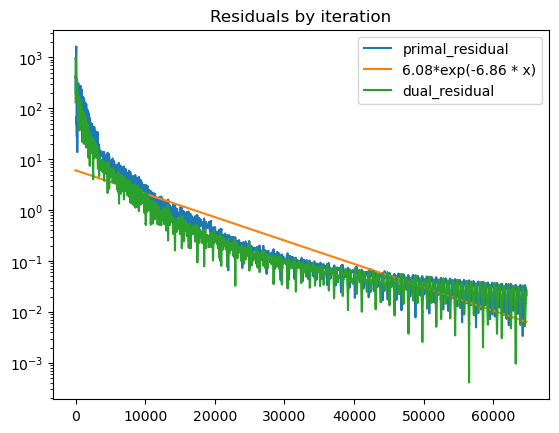

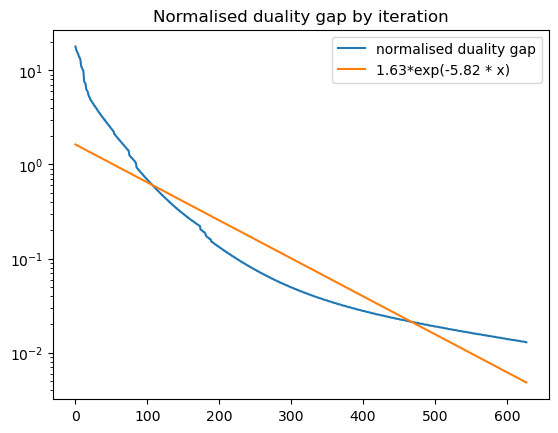

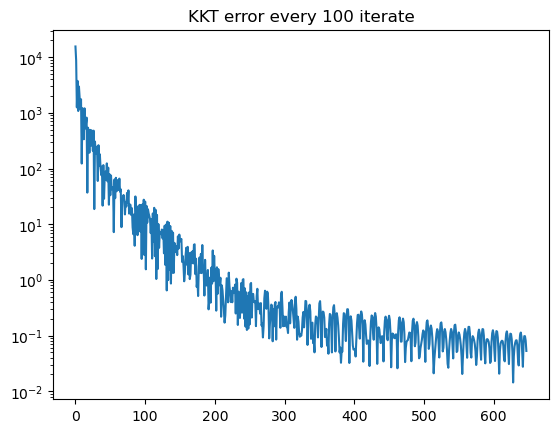

Restart at iteration 16 t= 16
Restart at iteration 32 t= 16
Restart at iteration 48 t= 16
Restart at iteration 64 t= 16
Restart at iteration 80 t= 16
Restart at iteration 96 t= 16
Restart at iteration 112 t= 16
Restart at iteration 128 t= 16
Restart at iteration 144 t= 16
Restart at iteration 160 t= 16
Restart at iteration 176 t= 16
Restart at iteration 192 t= 16
Restart at iteration 208 t= 16
Restart at iteration 224 t= 16
Restart at iteration 240 t= 16
Restart at iteration 256 t= 16
Restart at iteration 272 t= 16
Restart at iteration 288 t= 16
Restart at iteration 304 t= 16
Restart at iteration 320 t= 16
Restart at iteration 336 t= 16
Restart at iteration 352 t= 16
Restart at iteration 368 t= 16
Restart at iteration 384 t= 16
Restart at iteration 400 t= 16
Restart at iteration 416 t= 16
Restart at iteration 432 t= 16
Restart at iteration 448 t= 16
Restart at iteration 464 t= 16
Restart at iteration 480 t= 16
Restart at iteration 496 t= 16
Restart at iteration 512 t= 16
Restart at ite

Restart at iteration 4304 t= 16
Restart at iteration 4320 t= 16
Restart at iteration 4336 t= 16
Restart at iteration 4352 t= 16
Restart at iteration 4368 t= 16
Restart at iteration 4384 t= 16
Restart at iteration 4400 t= 16
Restart at iteration 4416 t= 16
Restart at iteration 4432 t= 16
Restart at iteration 4448 t= 16
Restart at iteration 4464 t= 16
Restart at iteration 4480 t= 16
Restart at iteration 4496 t= 16
Restart at iteration 4512 t= 16
Restart at iteration 4528 t= 16
Restart at iteration 4544 t= 16
Restart at iteration 4560 t= 16
Restart at iteration 4576 t= 16
Restart at iteration 4592 t= 16
Restart at iteration 4608 t= 16
Restart at iteration 4624 t= 16
Restart at iteration 4640 t= 16
Restart at iteration 4656 t= 16
Restart at iteration 4672 t= 16
Restart at iteration 4688 t= 16
Restart at iteration 4704 t= 16
Restart at iteration 4720 t= 16
Restart at iteration 4736 t= 16
Restart at iteration 4752 t= 16
Restart at iteration 4768 t= 16
Restart at iteration 4784 t= 16
Restart 

Restart at iteration 8704 t= 16
Restart at iteration 8720 t= 16
Restart at iteration 8736 t= 16
Restart at iteration 8752 t= 16
Restart at iteration 8768 t= 16
Restart at iteration 8784 t= 16
Restart at iteration 8800 t= 16
Restart at iteration 8816 t= 16
Restart at iteration 8832 t= 16
Restart at iteration 8848 t= 16
Restart at iteration 8864 t= 16
Restart at iteration 8880 t= 16
Restart at iteration 8896 t= 16
Restart at iteration 8912 t= 16
Restart at iteration 8928 t= 16
Restart at iteration 8944 t= 16
Restart at iteration 8960 t= 16
Restart at iteration 8976 t= 16
Restart at iteration 8992 t= 16
Restart at iteration 9008 t= 16
Restart at iteration 9024 t= 16
Restart at iteration 9040 t= 16
Restart at iteration 9056 t= 16
Restart at iteration 9072 t= 16
Restart at iteration 9088 t= 16
Restart at iteration 9104 t= 16
Restart at iteration 9120 t= 16
Restart at iteration 9136 t= 16
Restart at iteration 9152 t= 16
Restart at iteration 9168 t= 16
Restart at iteration 9184 t= 16
Restart 

Restart at iteration 13200 t= 16
Restart at iteration 13216 t= 16
Restart at iteration 13232 t= 16
Restart at iteration 13248 t= 16
Restart at iteration 13264 t= 16
Restart at iteration 13280 t= 16
Restart at iteration 13296 t= 16
Restart at iteration 13312 t= 16
Restart at iteration 13328 t= 16
Restart at iteration 13344 t= 16
Restart at iteration 13360 t= 16
Restart at iteration 13376 t= 16
Restart at iteration 13392 t= 16
Restart at iteration 13408 t= 16
Restart at iteration 13424 t= 16
Restart at iteration 13440 t= 16
Restart at iteration 13456 t= 16
Restart at iteration 13472 t= 16
Restart at iteration 13488 t= 16
Restart at iteration 13504 t= 16
Restart at iteration 13520 t= 16
Restart at iteration 13536 t= 16
Restart at iteration 13552 t= 16
Restart at iteration 13568 t= 16
Restart at iteration 13584 t= 16
Restart at iteration 13600 t= 16
Restart at iteration 13616 t= 16
Restart at iteration 13632 t= 16
Restart at iteration 13648 t= 16
Restart at iteration 13664 t= 16
Restart at

Restart at iteration 17600 t= 16
Restart at iteration 17616 t= 16
Restart at iteration 17632 t= 16
Restart at iteration 17648 t= 16
Restart at iteration 17664 t= 16
Restart at iteration 17680 t= 16
Restart at iteration 17696 t= 16
Restart at iteration 17712 t= 16
Restart at iteration 17728 t= 16
Restart at iteration 17744 t= 16
Restart at iteration 17760 t= 16
Restart at iteration 17776 t= 16
Restart at iteration 17792 t= 16
Restart at iteration 17808 t= 16
Restart at iteration 17824 t= 16
Restart at iteration 17840 t= 16
Restart at iteration 17856 t= 16
Restart at iteration 17872 t= 16
Restart at iteration 17888 t= 16
Restart at iteration 17904 t= 16
Restart at iteration 17920 t= 16
Restart at iteration 17936 t= 16
Restart at iteration 17952 t= 16
Restart at iteration 17968 t= 16
Restart at iteration 17984 t= 16
Restart at iteration 18000 t= 16
Restart at iteration 18016 t= 16
Restart at iteration 18032 t= 16
Restart at iteration 18048 t= 16
Restart at iteration 18064 t= 16
Restart at

Restart at iteration 22112 t= 16
Restart at iteration 22128 t= 16
Restart at iteration 22144 t= 16
Restart at iteration 22160 t= 16
Restart at iteration 22176 t= 16
Restart at iteration 22192 t= 16
Restart at iteration 22208 t= 16
Restart at iteration 22224 t= 16
Restart at iteration 22240 t= 16
Restart at iteration 22256 t= 16
Restart at iteration 22272 t= 16
Restart at iteration 22288 t= 16
Restart at iteration 22304 t= 16
Restart at iteration 22320 t= 16
Restart at iteration 22336 t= 16
Restart at iteration 22352 t= 16
Restart at iteration 22368 t= 16
Restart at iteration 22384 t= 16
Restart at iteration 22400 t= 16
Restart at iteration 22416 t= 16
Restart at iteration 22432 t= 16
Restart at iteration 22448 t= 16
Restart at iteration 22464 t= 16
Restart at iteration 22480 t= 16
Restart at iteration 22496 t= 16
Restart at iteration 22512 t= 16
Restart at iteration 22528 t= 16
Restart at iteration 22544 t= 16
Restart at iteration 22560 t= 16
Restart at iteration 22576 t= 16
Restart at

Restart at iteration 26704 t= 16
Restart at iteration 26720 t= 16
Restart at iteration 26736 t= 16
Restart at iteration 26752 t= 16
Restart at iteration 26768 t= 16
Restart at iteration 26784 t= 16
Restart at iteration 26800 t= 16
Restart at iteration 26816 t= 16
Restart at iteration 26832 t= 16
Restart at iteration 26848 t= 16
Restart at iteration 26864 t= 16
Restart at iteration 26880 t= 16
Restart at iteration 26896 t= 16
Restart at iteration 26912 t= 16
Restart at iteration 26928 t= 16
Restart at iteration 26944 t= 16
Restart at iteration 26960 t= 16
Restart at iteration 26976 t= 16
Restart at iteration 26992 t= 16
Restart at iteration 27008 t= 16
Restart at iteration 27024 t= 16
Restart at iteration 27040 t= 16
Restart at iteration 27056 t= 16
Restart at iteration 27072 t= 16
Restart at iteration 27088 t= 16
Restart at iteration 27104 t= 16
Restart at iteration 27120 t= 16
Restart at iteration 27136 t= 16
Restart at iteration 27152 t= 16
Restart at iteration 27168 t= 16
Restart at

Restart at iteration 31104 t= 16
Restart at iteration 31120 t= 16
Restart at iteration 31136 t= 16
Restart at iteration 31152 t= 16
Restart at iteration 31168 t= 16
Restart at iteration 31184 t= 16
Restart at iteration 31200 t= 16
Restart at iteration 31216 t= 16
Restart at iteration 31232 t= 16
Restart at iteration 31248 t= 16
Restart at iteration 31264 t= 16
Restart at iteration 31280 t= 16
Restart at iteration 31296 t= 16
Restart at iteration 31312 t= 16
Restart at iteration 31328 t= 16
Restart at iteration 31344 t= 16
Restart at iteration 31360 t= 16
Restart at iteration 31376 t= 16
Restart at iteration 31392 t= 16
Restart at iteration 31408 t= 16
Restart at iteration 31424 t= 16
Restart at iteration 31440 t= 16
Restart at iteration 31456 t= 16
Restart at iteration 31472 t= 16
Restart at iteration 31488 t= 16
Restart at iteration 31504 t= 16
Restart at iteration 31520 t= 16
Restart at iteration 31536 t= 16
Restart at iteration 31552 t= 16
Restart at iteration 31568 t= 16
Restart at

Restart at iteration 35200 t= 16
Restart at iteration 35216 t= 16
Restart at iteration 35232 t= 16
Restart at iteration 35248 t= 16
Restart at iteration 35264 t= 16
Restart at iteration 35280 t= 16
Restart at iteration 35296 t= 16
Restart at iteration 35312 t= 16
Restart at iteration 35328 t= 16
Restart at iteration 35344 t= 16
Restart at iteration 35360 t= 16
Restart at iteration 35376 t= 16
Restart at iteration 35392 t= 16
Restart at iteration 35408 t= 16
Restart at iteration 35424 t= 16
Restart at iteration 35440 t= 16
Restart at iteration 35456 t= 16
Restart at iteration 35472 t= 16
Restart at iteration 35488 t= 16
Restart at iteration 35504 t= 16
Restart at iteration 35520 t= 16
Restart at iteration 35536 t= 16
Restart at iteration 35552 t= 16
Restart at iteration 35568 t= 16
Restart at iteration 35584 t= 16
Restart at iteration 35600 t= 16
Restart at iteration 35616 t= 16
Restart at iteration 35632 t= 16
Restart at iteration 35648 t= 16
Restart at iteration 35664 t= 16
Restart at

Restart at iteration 39712 t= 16
Restart at iteration 39728 t= 16
Restart at iteration 39744 t= 16
Restart at iteration 39760 t= 16
Restart at iteration 39776 t= 16
Restart at iteration 39792 t= 16
Restart at iteration 39808 t= 16
Restart at iteration 39824 t= 16
Restart at iteration 39840 t= 16
Restart at iteration 39856 t= 16
Restart at iteration 39872 t= 16
Restart at iteration 39888 t= 16
Restart at iteration 39904 t= 16
Restart at iteration 39920 t= 16
Restart at iteration 39936 t= 16
Restart at iteration 39952 t= 16
Restart at iteration 39968 t= 16
Restart at iteration 39984 t= 16
Restart at iteration 40000 t= 16
Restart at iteration 40016 t= 16
Restart at iteration 40032 t= 16
Restart at iteration 40048 t= 16
Restart at iteration 40064 t= 16
Restart at iteration 40080 t= 16
Restart at iteration 40096 t= 16
Restart at iteration 40112 t= 16
Restart at iteration 40128 t= 16
Restart at iteration 40144 t= 16
Restart at iteration 40160 t= 16
Restart at iteration 40176 t= 16
Restart at

Restart at iteration 44304 t= 16
Restart at iteration 44320 t= 16
Restart at iteration 44336 t= 16
Restart at iteration 44352 t= 16
Restart at iteration 44368 t= 16
Restart at iteration 44384 t= 16
Restart at iteration 44400 t= 16
Restart at iteration 44416 t= 16
Restart at iteration 44432 t= 16
Restart at iteration 44448 t= 16
Restart at iteration 44464 t= 16
Restart at iteration 44480 t= 16
Restart at iteration 44496 t= 16
Restart at iteration 44512 t= 16
Restart at iteration 44528 t= 16
Restart at iteration 44544 t= 16
Restart at iteration 44560 t= 16
Restart at iteration 44576 t= 16
Restart at iteration 44592 t= 16
Restart at iteration 44608 t= 16
Restart at iteration 44624 t= 16
Restart at iteration 44640 t= 16
Restart at iteration 44656 t= 16
Restart at iteration 44672 t= 16
Restart at iteration 44688 t= 16
Restart at iteration 44704 t= 16
Restart at iteration 44720 t= 16
Restart at iteration 44736 t= 16
Restart at iteration 44752 t= 16
Restart at iteration 44768 t= 16
Restart at

Restart at iteration 48800 t= 16
Restart at iteration 48816 t= 16
Restart at iteration 48832 t= 16
Restart at iteration 48848 t= 16
Restart at iteration 48864 t= 16
Restart at iteration 48880 t= 16
Restart at iteration 48896 t= 16
Restart at iteration 48912 t= 16
Restart at iteration 48928 t= 16
Restart at iteration 48944 t= 16
Restart at iteration 48960 t= 16
Restart at iteration 48976 t= 16
Restart at iteration 48992 t= 16
Restart at iteration 49008 t= 16
Restart at iteration 49024 t= 16
Restart at iteration 49040 t= 16
Restart at iteration 49056 t= 16
Restart at iteration 49072 t= 16
Restart at iteration 49088 t= 16
Restart at iteration 49104 t= 16
Restart at iteration 49120 t= 16
Restart at iteration 49136 t= 16
Restart at iteration 49152 t= 16
Restart at iteration 49168 t= 16
Restart at iteration 49184 t= 16
Restart at iteration 49200 t= 16
Restart at iteration 49216 t= 16
Restart at iteration 49232 t= 16
Restart at iteration 49248 t= 16
Restart at iteration 49264 t= 16
Restart at

Restart at iteration 53008 t= 16
Restart at iteration 53024 t= 16
Restart at iteration 53040 t= 16
Restart at iteration 53056 t= 16
Restart at iteration 53072 t= 16
Restart at iteration 53088 t= 16
Restart at iteration 53104 t= 16
Restart at iteration 53120 t= 16
Restart at iteration 53136 t= 16
Restart at iteration 53152 t= 16
Restart at iteration 53168 t= 16
Restart at iteration 53184 t= 16
Restart at iteration 53200 t= 16
Restart at iteration 53216 t= 16
Restart at iteration 53232 t= 16
Restart at iteration 53248 t= 16
Restart at iteration 53264 t= 16
Restart at iteration 53280 t= 16
Restart at iteration 53296 t= 16
Restart at iteration 53312 t= 16
Restart at iteration 53328 t= 16
Restart at iteration 53344 t= 16
Restart at iteration 53360 t= 16
Restart at iteration 53376 t= 16
Restart at iteration 53392 t= 16
Restart at iteration 53408 t= 16
Restart at iteration 53424 t= 16
Restart at iteration 53440 t= 16
Restart at iteration 53456 t= 16
Restart at iteration 53472 t= 16
Restart at

Restart at iteration 57312 t= 16
Restart at iteration 57328 t= 16
Restart at iteration 57344 t= 16
Restart at iteration 57360 t= 16
Restart at iteration 57376 t= 16
Restart at iteration 57392 t= 16
Restart at iteration 57408 t= 16
Restart at iteration 57424 t= 16
Restart at iteration 57440 t= 16
Restart at iteration 57456 t= 16
Restart at iteration 57472 t= 16
Restart at iteration 57488 t= 16
Restart at iteration 57504 t= 16
Restart at iteration 57520 t= 16
Restart at iteration 57536 t= 16
Restart at iteration 57552 t= 16
Restart at iteration 57568 t= 16
Restart at iteration 57584 t= 16
Restart at iteration 57600 t= 16
Restart at iteration 57616 t= 16
Restart at iteration 57632 t= 16
Restart at iteration 57648 t= 16
Restart at iteration 57664 t= 16
Restart at iteration 57680 t= 16
Restart at iteration 57696 t= 16
Restart at iteration 57712 t= 16
Restart at iteration 57728 t= 16
Restart at iteration 57744 t= 16
Restart at iteration 57760 t= 16
Restart at iteration 57776 t= 16
Restart at

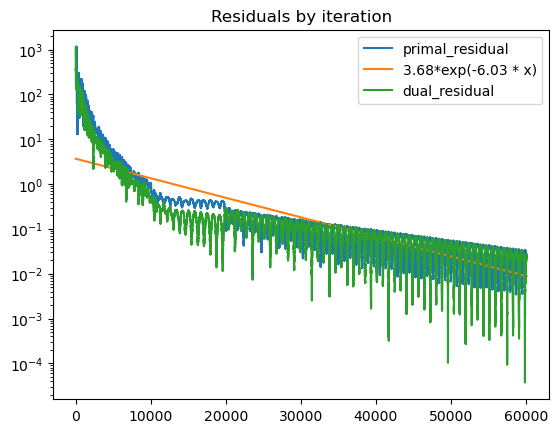

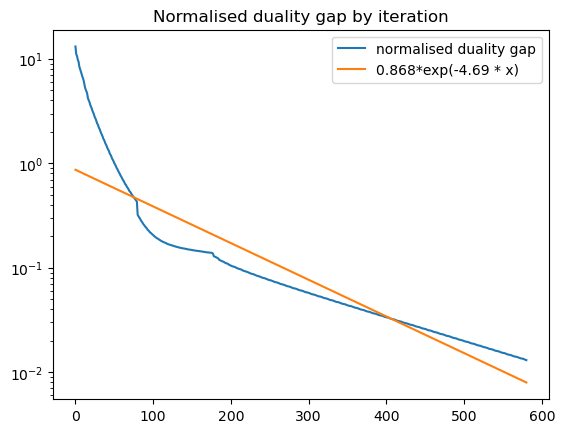

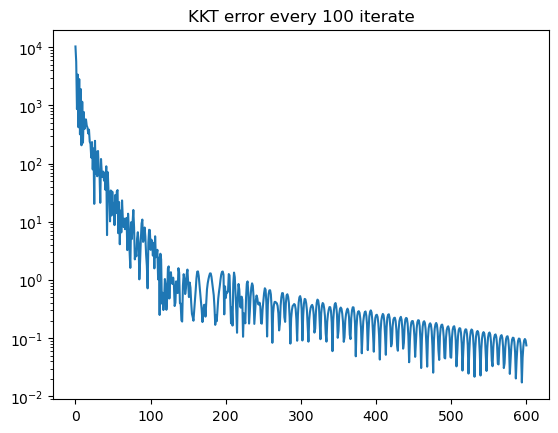

Restart at iteration 64 t= 64
Restart at iteration 128 t= 64
Restart at iteration 192 t= 64
Restart at iteration 256 t= 64
Restart at iteration 320 t= 64
Restart at iteration 384 t= 64
Restart at iteration 448 t= 64
Restart at iteration 512 t= 64
Restart at iteration 576 t= 64
Restart at iteration 640 t= 64
Restart at iteration 704 t= 64
Restart at iteration 768 t= 64
Restart at iteration 832 t= 64
Restart at iteration 896 t= 64
Restart at iteration 960 t= 64
Restart at iteration 1024 t= 64
Restart at iteration 1088 t= 64
Restart at iteration 1152 t= 64
Restart at iteration 1216 t= 64
Restart at iteration 1280 t= 64
Restart at iteration 1344 t= 64
Restart at iteration 1408 t= 64
Restart at iteration 1472 t= 64
Restart at iteration 1536 t= 64
Restart at iteration 1600 t= 64
Restart at iteration 1664 t= 64
Restart at iteration 1728 t= 64
Restart at iteration 1792 t= 64
Restart at iteration 1856 t= 64
Restart at iteration 1920 t= 64
Restart at iteration 1984 t= 64
Restart at iteration 204

Restart at iteration 16704 t= 64
Restart at iteration 16768 t= 64
Restart at iteration 16832 t= 64
Restart at iteration 16896 t= 64
Restart at iteration 16960 t= 64
Restart at iteration 17024 t= 64
Restart at iteration 17088 t= 64
Restart at iteration 17152 t= 64
Restart at iteration 17216 t= 64
Restart at iteration 17280 t= 64
Restart at iteration 17344 t= 64
Restart at iteration 17408 t= 64
Restart at iteration 17472 t= 64
Restart at iteration 17536 t= 64
Restart at iteration 17600 t= 64
Restart at iteration 17664 t= 64
Restart at iteration 17728 t= 64
Restart at iteration 17792 t= 64
Restart at iteration 17856 t= 64
Restart at iteration 17920 t= 64
Restart at iteration 17984 t= 64
Restart at iteration 18048 t= 64
Restart at iteration 18112 t= 64
Restart at iteration 18176 t= 64
Restart at iteration 18240 t= 64
Restart at iteration 18304 t= 64
Restart at iteration 18368 t= 64
Restart at iteration 18432 t= 64
Restart at iteration 18496 t= 64
Restart at iteration 18560 t= 64
Restart at

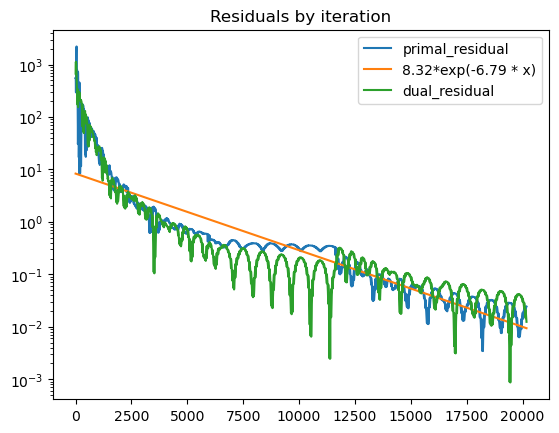

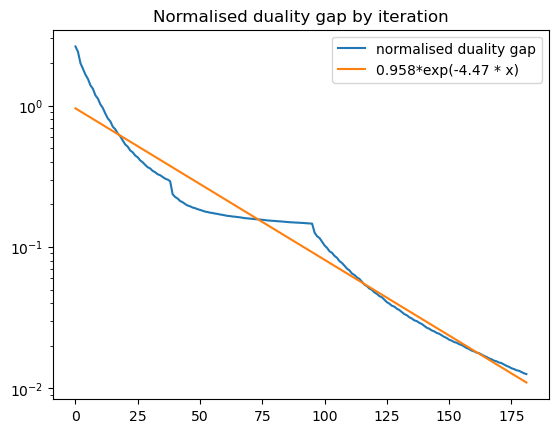

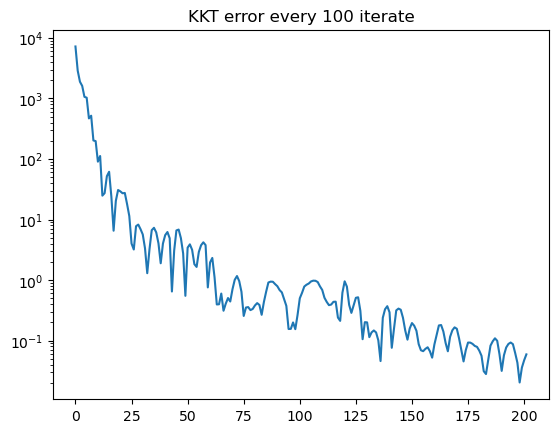

Restart at iteration 256 t= 256
Restart at iteration 512 t= 256
Restart at iteration 768 t= 256
Restart at iteration 1024 t= 256
Restart at iteration 1280 t= 256
Restart at iteration 1536 t= 256
Restart at iteration 1792 t= 256
Restart at iteration 2048 t= 256
Restart at iteration 2304 t= 256
Restart at iteration 2560 t= 256
Restart at iteration 2816 t= 256
Restart at iteration 3072 t= 256
Restart at iteration 3328 t= 256
Restart at iteration 3584 t= 256
Restart at iteration 3840 t= 256
Restart at iteration 4096 t= 256
Restart at iteration 4352 t= 256
Restart at iteration 4608 t= 256
Restart at iteration 4864 t= 256
Restart at iteration 5120 t= 256
Restart at iteration 5376 t= 256
Restart at iteration 5632 t= 256
Restart at iteration 5888 t= 256
Restart at iteration 6144 t= 256
Restart at iteration 6400 t= 256
Restart at iteration 6656 t= 256
Restart at iteration 6912 t= 256
Restart at iteration 7168 t= 256
Restart at iteration 7424 t= 256
Restart at iteration 7680 t= 256
Restart at it

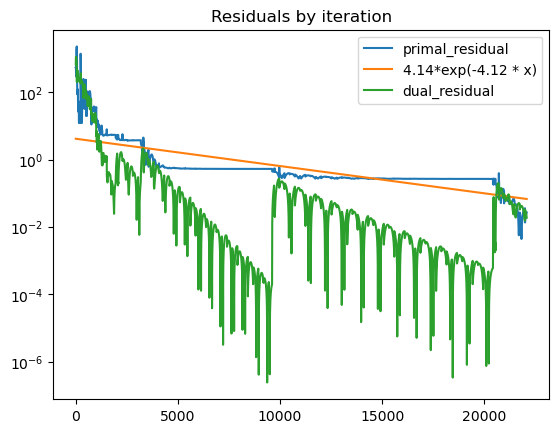

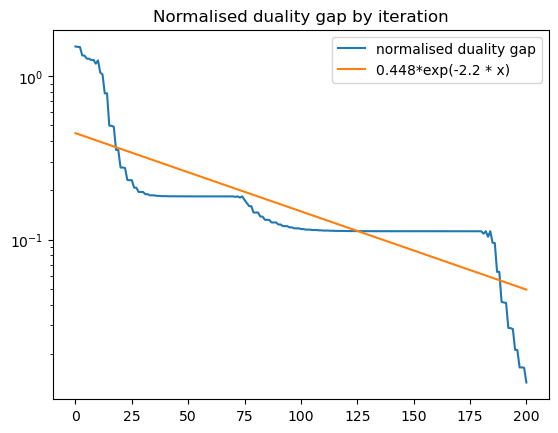

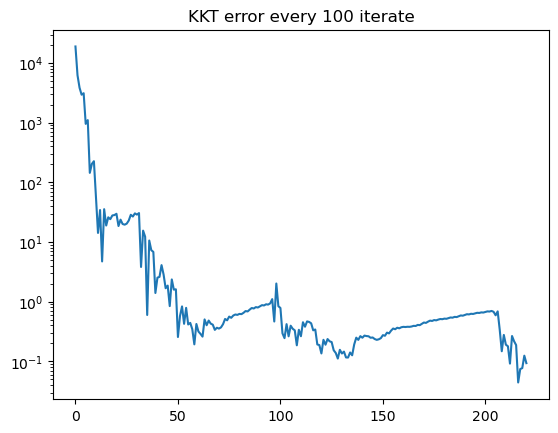

Restart at iteration 1024 t= 1024
Restart at iteration 2048 t= 1024
Restart at iteration 3072 t= 1024
Restart at iteration 4096 t= 1024
Restart at iteration 5120 t= 1024
Restart at iteration 6144 t= 1024
Restart at iteration 7168 t= 1024
Restart at iteration 8192 t= 1024
Restart at iteration 9216 t= 1024
Restart at iteration 10240 t= 1024
Restart at iteration 11264 t= 1024
Restart at iteration 12288 t= 1024
Restart at iteration 13312 t= 1024
Restart at iteration 14336 t= 1024
Restart at iteration 15360 t= 1024
Restart at iteration 16384 t= 1024
Restart at iteration 17408 t= 1024
Restart at iteration 18432 t= 1024
Restart at iteration 19456 t= 1024
Restart at iteration 20480 t= 1024
Termination Criteria reached for average iterate at iteration 20700
final primal_stepsize 0.009995838611215802 final dual_stepsize 0.015075592406902961


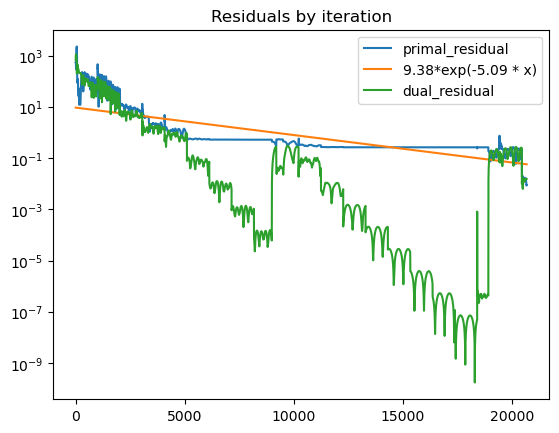

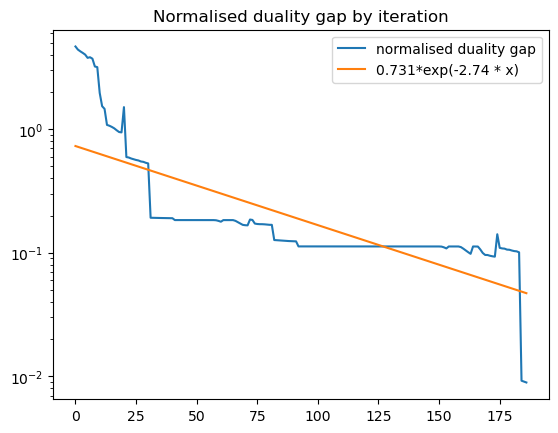

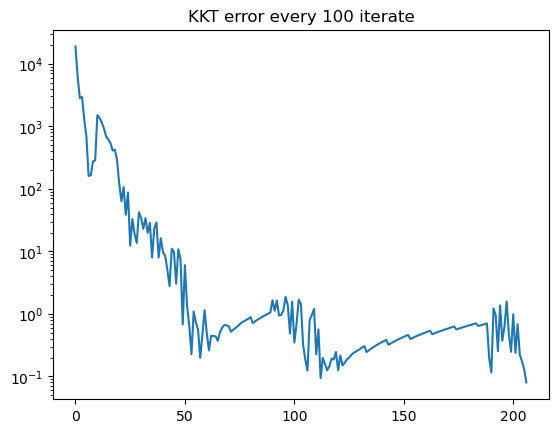

Restart at iteration 4096 t= 4096
Restart at iteration 8192 t= 4096
Restart at iteration 12288 t= 4096
Restart at iteration 16384 t= 4096
Restart at iteration 20480 t= 4096
Restart at iteration 24576 t= 4096
Termination Criteria reached for average iterate at iteration 26000
final primal_stepsize 0.009995838611215802 final dual_stepsize 0.015075592406902961


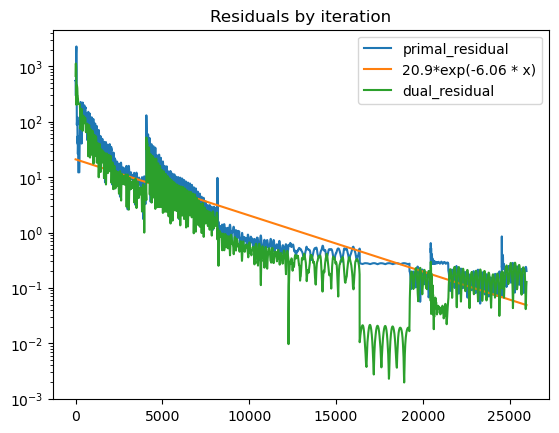

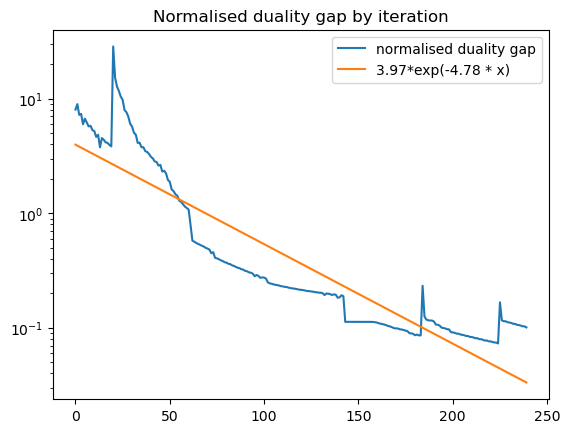

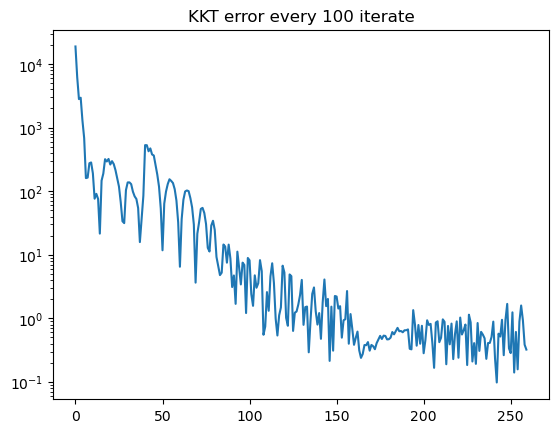

Restart at iteration 16384 t= 16384
Restart at iteration 32768 t= 16384
Termination Criteria reached for average iterate at iteration 38600
final primal_stepsize 0.009995838611215802 final dual_stepsize 0.015075592406902961


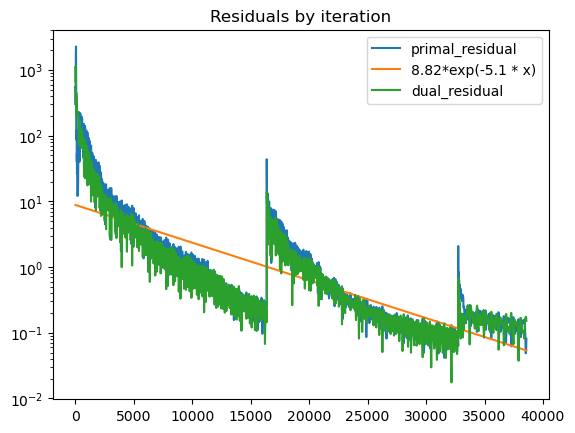

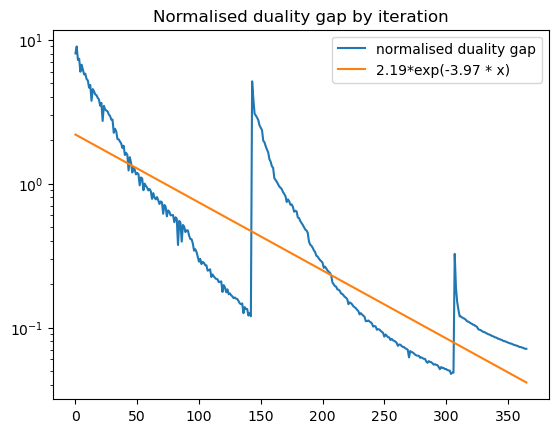

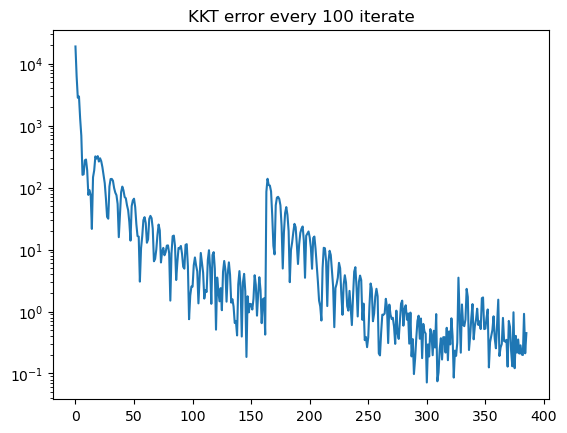

Restart at iteration 65536 t= 65536
Termination Criteria reached for average iterate at iteration 95600
final primal_stepsize 0.009995838611215802 final dual_stepsize 0.015075592406902961


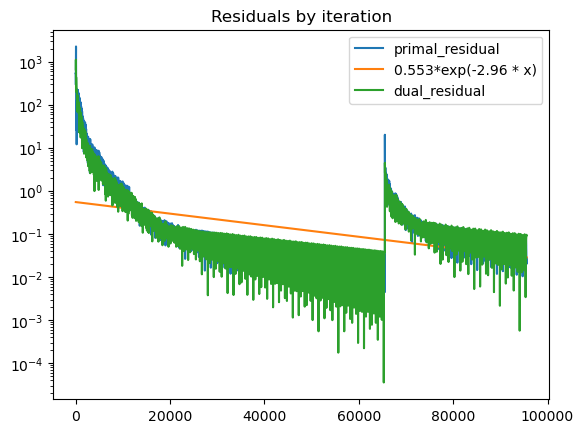

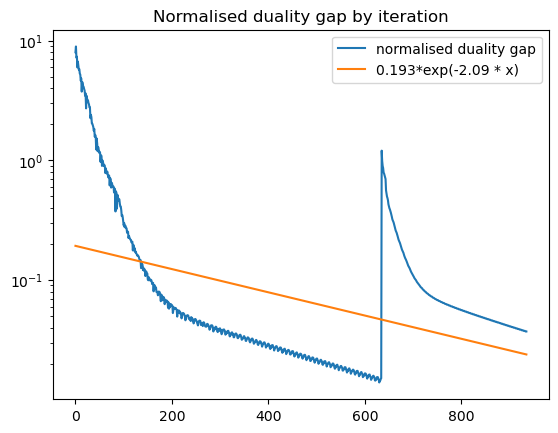

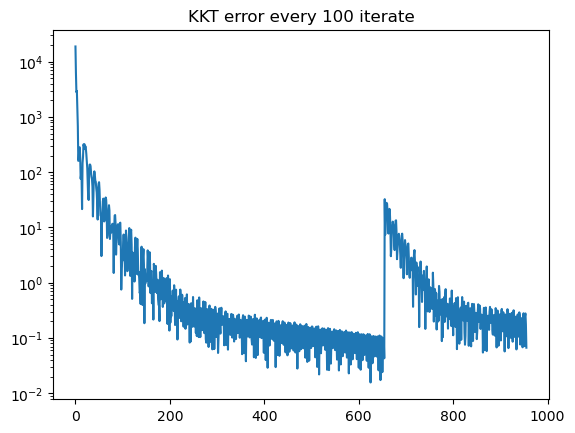

Termination Criteria reached for last iterate at iteration 71700
final primal_stepsize 0.009995838611215802 final dual_stepsize 0.015075592406902961


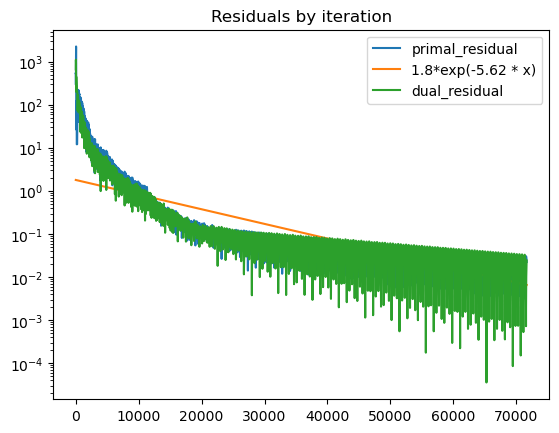

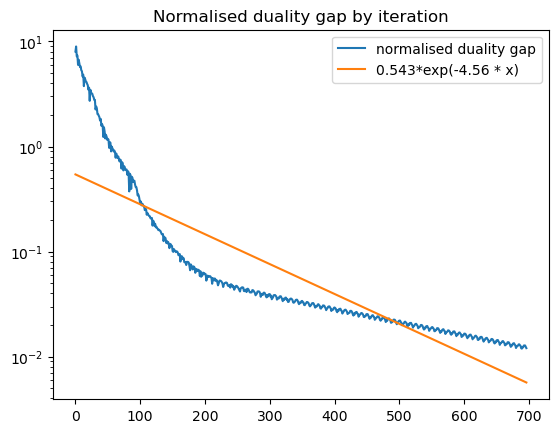

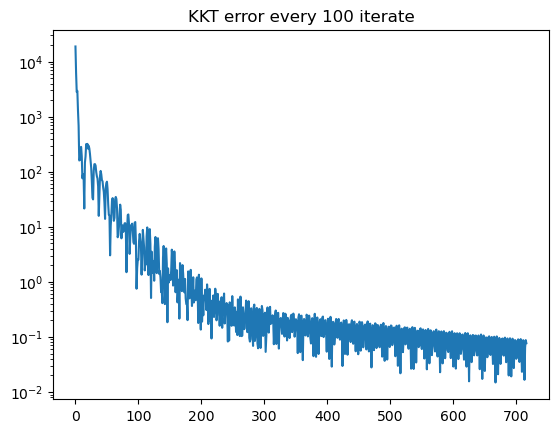

In [182]:
z0=np.zeros((dim+m1+m2,1))
break_val=100000
results=dict()
for restart in [4**i for i in range(1,10)]:
    x,y,list_min,k,list_last,list_average=AdaptativeRestartPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-4,
                                    break_val=break_val,verbose=False,s='max',termination='other',restart=restart,
                                    adaptative=True,n_before_print=100,beta=0.8,adaptative_restart=False)
    results[restart]=k

In [191]:
temp=pd.DataFrame(results.values(),results.keys()).reset_index().rename({'index':'restart_length',0:'num_iter'},axis=1)
display(temp)

restart_length  num_iter
0               4     64800
1              16     60100
2              64     20200
3             256     22100
4            1024     20700
5            4096     26000
6           16384     38600
7           65536     95600
8          262144     71700

Restart at iteration 2 t= 2
Restart at iteration 65 t= 63
Restart at iteration 129 t= 64
Restart at iteration 193 t= 64
Restart at iteration 257 t= 64
Restart at iteration 321 t= 64
Restart at iteration 385 t= 64
Restart at iteration 449 t= 64
Restart at iteration 513 t= 64
Restart at iteration 577 t= 64
Restart at iteration 641 t= 64
Restart at iteration 705 t= 64
Restart at iteration 769 t= 64
Restart at iteration 833 t= 64
Restart at iteration 897 t= 64
Restart at iteration 961 t= 64
Restart at iteration 1025 t= 64
Restart at iteration 1089 t= 64
Restart at iteration 1153 t= 64
Restart at iteration 1217 t= 64
Restart at iteration 2497 t= 1280
Restart at iteration 2561 t= 64
Restart at iteration 2625 t= 64
Restart at iteration 5313 t= 2688
Restart at iteration 5377 t= 64
Restart at iteration 5441 t= 64
Restart at iteration 10945 t= 5504
Restart at iteration 11009 t= 64
Restart at iteration 11073 t= 64
Restart at iteration 11137 t= 64
Restart at iteration 22337 t= 11200
Restart at ite

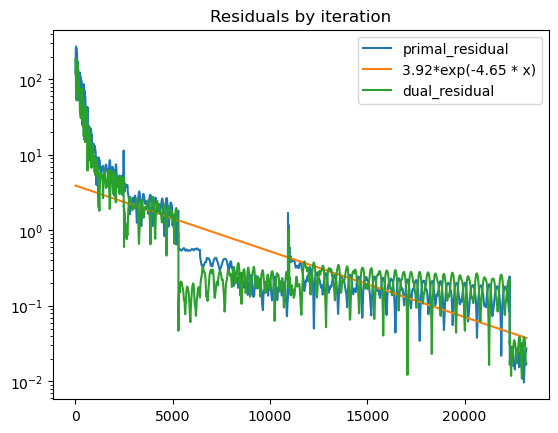

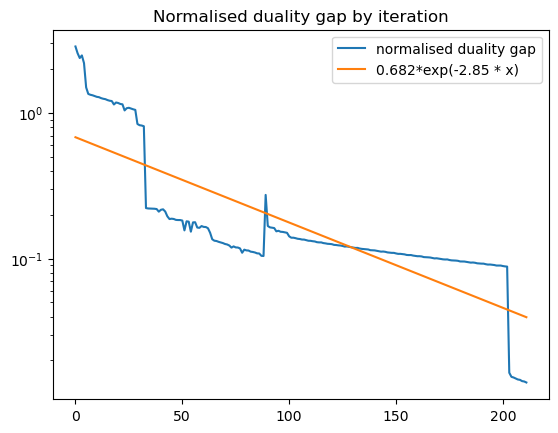

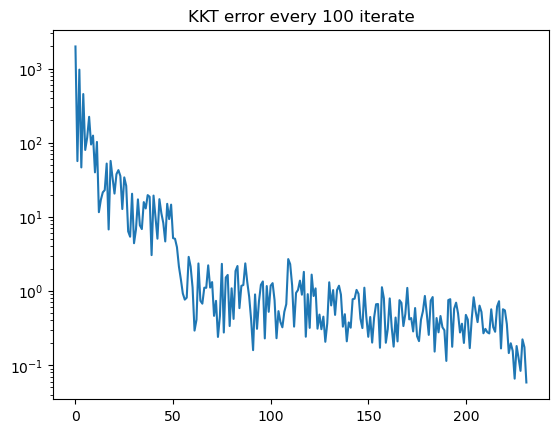

Restart at iteration 2 t= 2
Restart at iteration 257 t= 255
Restart at iteration 513 t= 256
Restart at iteration 769 t= 256
Restart at iteration 1025 t= 256
Restart at iteration 1281 t= 256
Restart at iteration 1537 t= 256
Restart at iteration 3329 t= 1792
Restart at iteration 3585 t= 256
Restart at iteration 3841 t= 256
Restart at iteration 4097 t= 256
Restart at iteration 4353 t= 256
Restart at iteration 4609 t= 256
Restart at iteration 9473 t= 4864
Restart at iteration 9729 t= 256
Restart at iteration 9985 t= 256
Restart at iteration 10241 t= 256
Restart at iteration 20737 t= 10496
Termination Criteria reached at iteration 20800


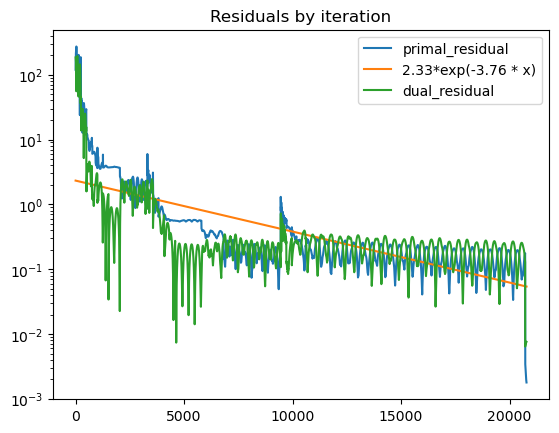

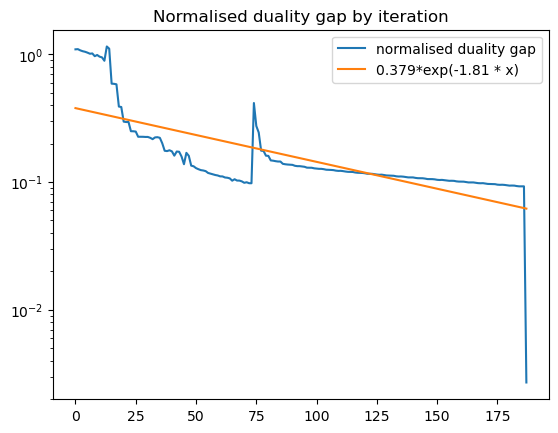

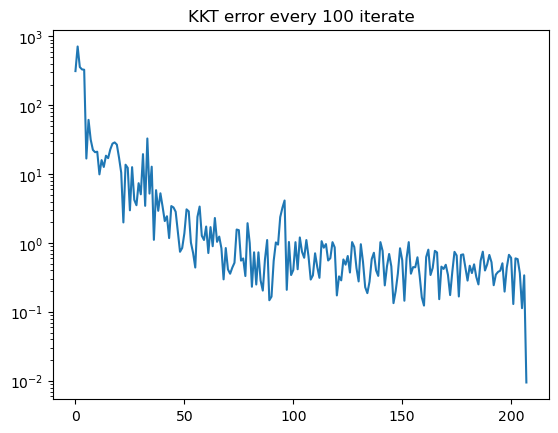

Restart at iteration 2 t= 2
Restart at iteration 1025 t= 1023
Restart at iteration 2049 t= 1024
Restart at iteration 3073 t= 1024
Restart at iteration 4097 t= 1024
Restart at iteration 5121 t= 1024
Restart at iteration 11265 t= 6144
Restart at iteration 12289 t= 1024
Restart at iteration 13313 t= 1024
Restart at iteration 14337 t= 1024
Termination Criteria reached at iteration 14400


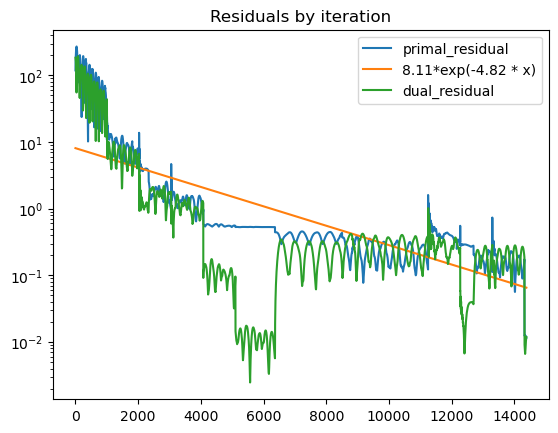

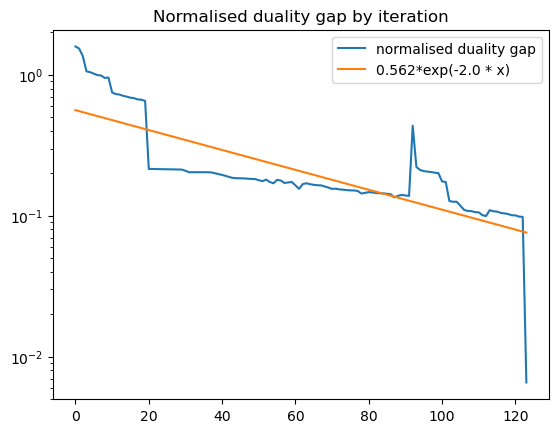

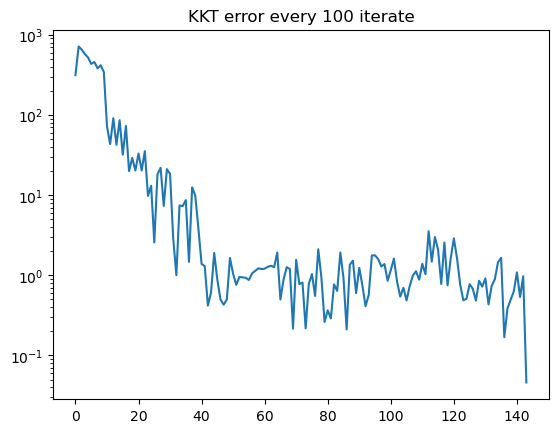

Restart at iteration 2 t= 2
Restart at iteration 4097 t= 4095
Restart at iteration 8193 t= 4096
Restart at iteration 12289 t= 4096
Restart at iteration 16385 t= 4096
Restart at iteration 20481 t= 4096
Termination Criteria reached at iteration 20500


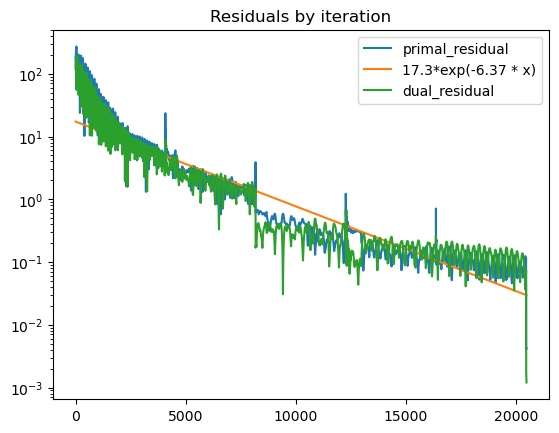

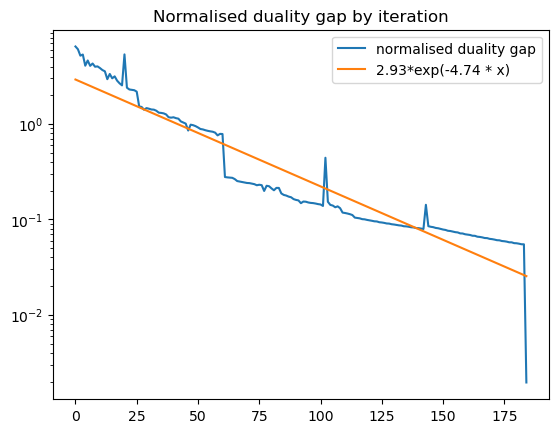

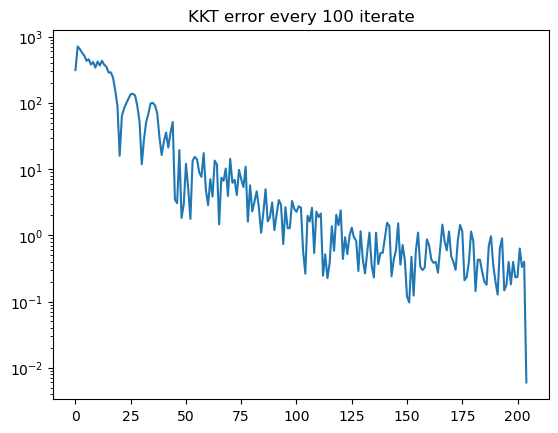

Restart at iteration 2 t= 2
Restart at iteration 16385 t= 16383
Restart at iteration 32769 t= 16384
Termination Criteria reached at iteration 32800


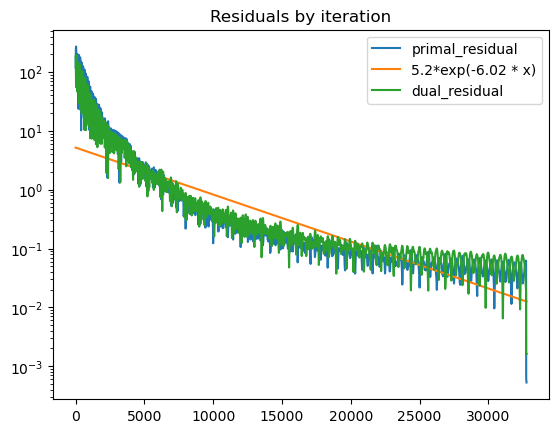

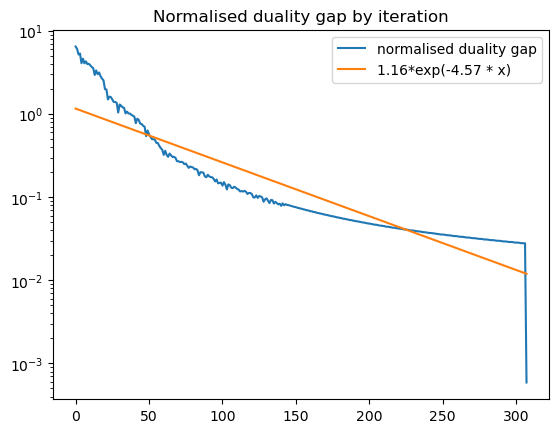

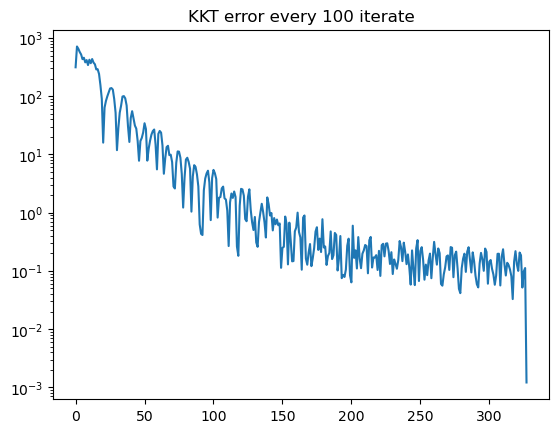

Restart at iteration 2 t= 2
Termination Criteria reached at iteration 57400


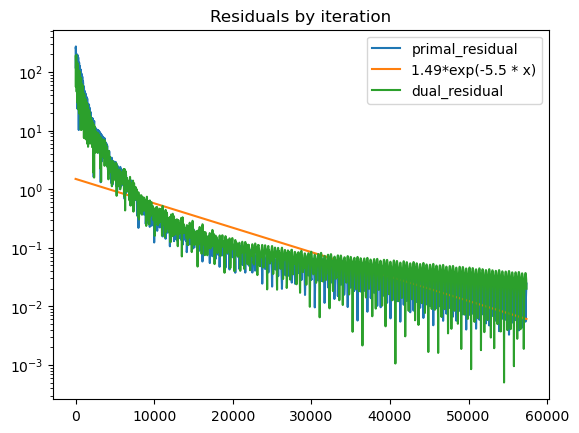

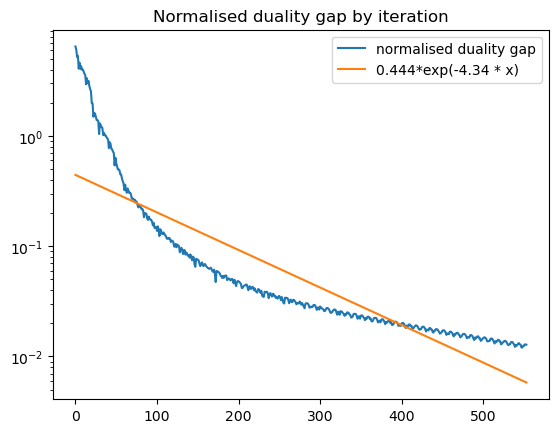

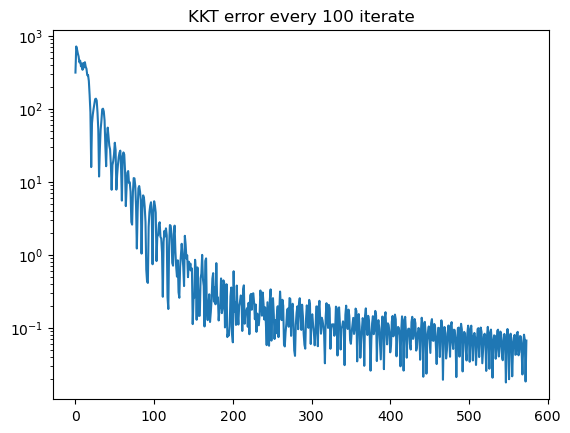

Restart at iteration 2 t= 2
Termination Criteria reached at iteration 57400


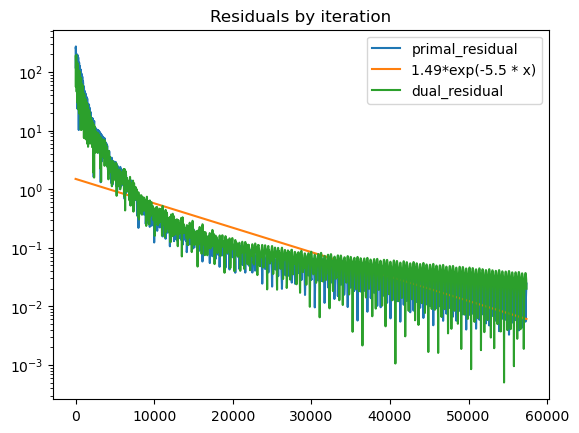

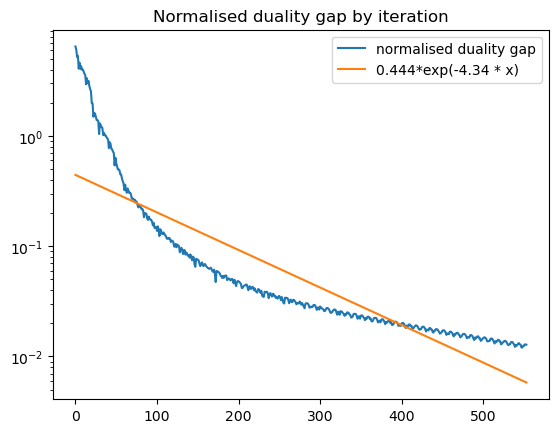

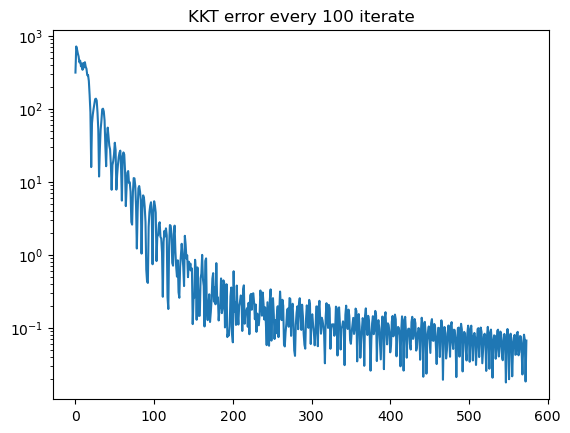

In [198]:
z0=np.zeros((dim+m1+m2,1))
break_val=0
results=dict()
for restart in [4**i for i in range(3,10)]:
    x3,y3,k=RestartedPDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-4,
                        break_val=break_val, tau0=1,verbose=False,n_before_print=100,min_restart=restart)
    results[restart]=k


In [199]:
temp=pd.DataFrame(results.values(),results.keys()).reset_index().rename({'index':'min_restart_length',0:'num_iter'},axis=1)
display(temp)

min_restart_length  num_iter
0                  64     23200
1                 256     20800
2                1024     14400
3                4096     20500
4               16384     32800
5               65536     57400
6              262144     57400

Restart at iteration 2 t= 2
Restart at iteration 251 t= 249
0.9166755792793101
Restart at iteration 501 t= 250
0.47450653184179037
Restart at iteration 751 t= 250
0.6434745025531882
Restart at iteration 1001 t= 250
0.3949130757481073
Restart at iteration 1251 t= 250
0.27954839280977745
Restart at iteration 1501 t= 250
0.11804181953254639
Restart at iteration 1751 t= 250
0.22957221053857016
Restart at iteration 2001 t= 250
0.1361492622960409
Restart at iteration 4251 t= 2250
0.07879739538238861
Restart at iteration 4501 t= 250
0.12842830177533618
Restart at iteration 4751 t= 250
0.0658721040614996
Restart at iteration 5001 t= 250
0.10290482713935142
Restart at iteration 5251 t= 250
0.13254361925425162
Restart at iteration 5501 t= 250
0.09723113224218981
Restart at iteration 5751 t= 250
0.07511062035988562
Termination Criteria reached at iteration 6000


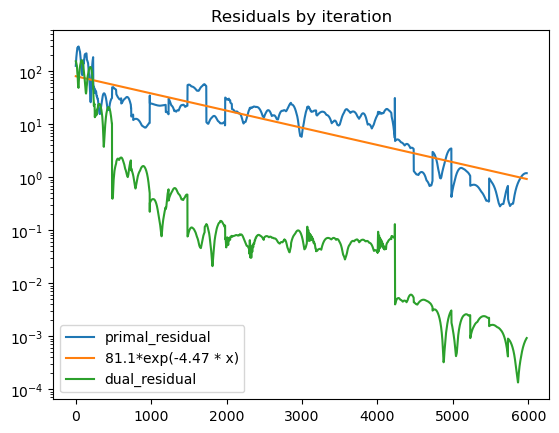

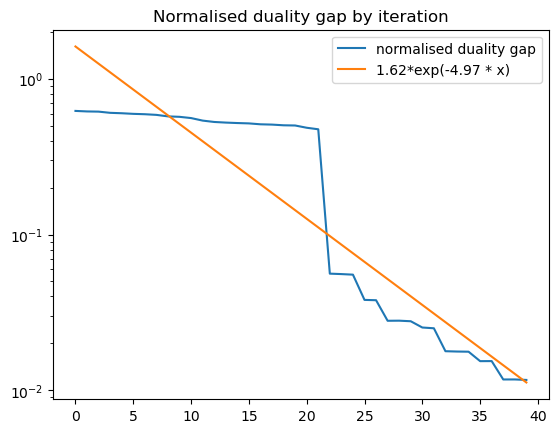

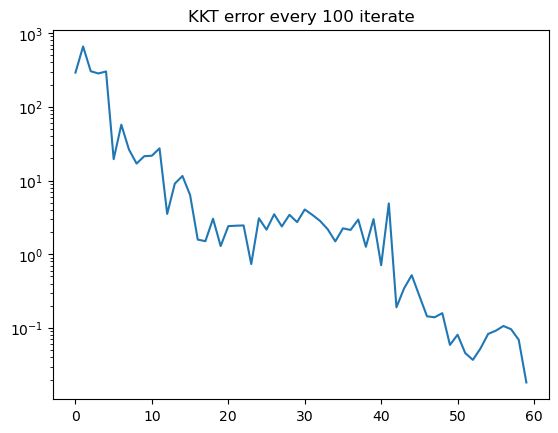

Restart at iteration 2 t= 2
Restart at iteration 501 t= 499
0.9166755792793101
Restart at iteration 1001 t= 500
0.4551518192056527
Restart at iteration 1501 t= 500
0.4432511523680275
Restart at iteration 2001 t= 500
0.23727789839215896
Restart at iteration 2501 t= 500
0.200174894182682
Restart at iteration 3001 t= 500
0.0905313030924834
Restart at iteration 3501 t= 500
0.05803747587830907
Restart at iteration 4001 t= 500
0.06919192217597057
Restart at iteration 4501 t= 500
0.060924533947664124
Termination Criteria reached at iteration 4900


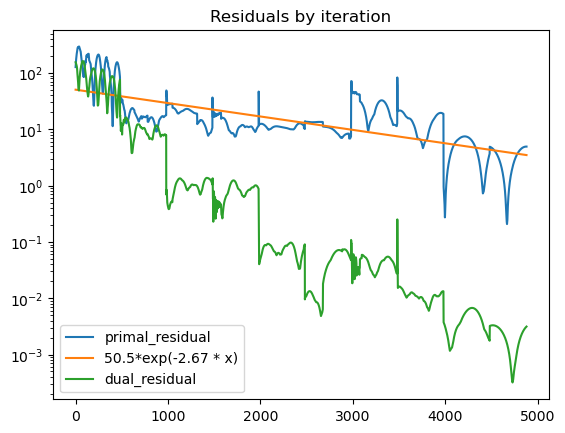

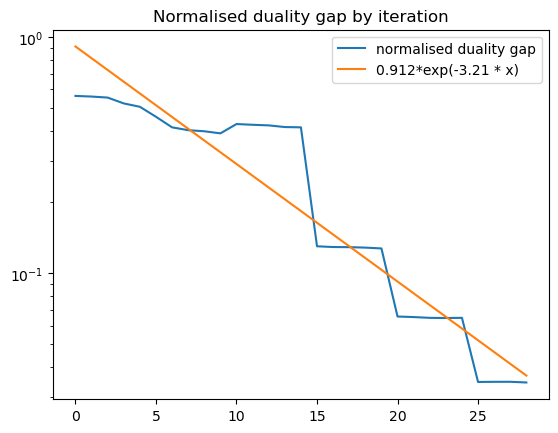

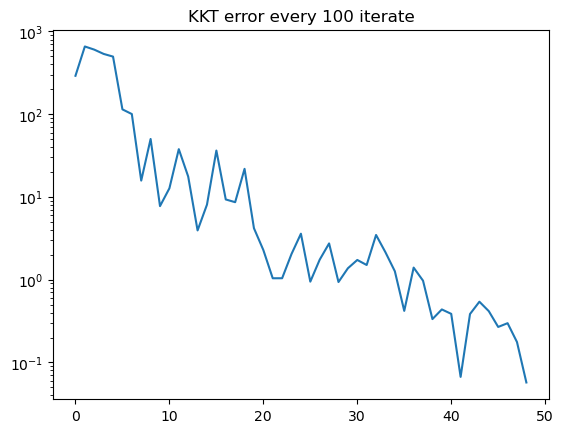

Restart at iteration 2 t= 2
Restart at iteration 751 t= 749
0.9166755792793101
Restart at iteration 1501 t= 750
0.42589593247447377
Restart at iteration 2251 t= 750
0.3219941417481595
Restart at iteration 3001 t= 750
0.19831577081311239
Restart at iteration 3751 t= 750
0.133516972865419
Restart at iteration 4501 t= 750
0.07361007693892109
Restart at iteration 5251 t= 750
0.054399868121611225
Restart at iteration 6001 t= 750
0.1057207481986817
Termination Criteria reached at iteration 6100


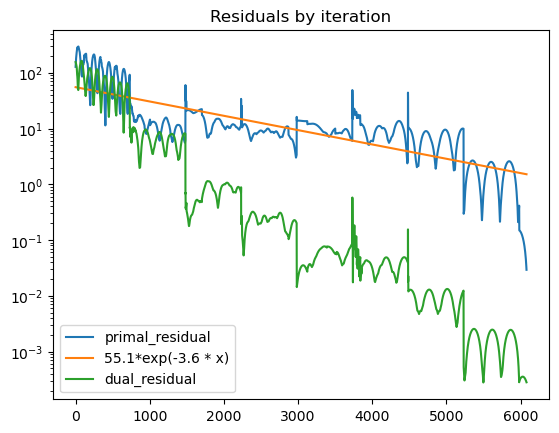

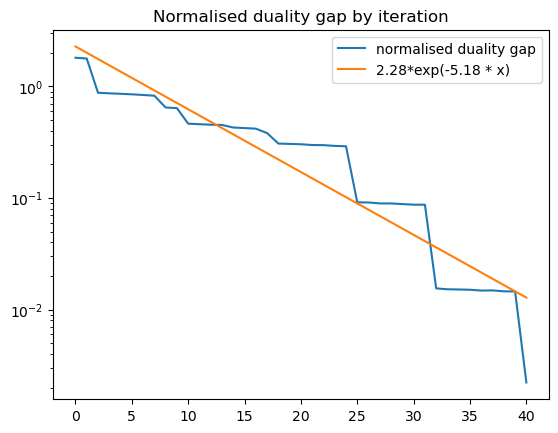

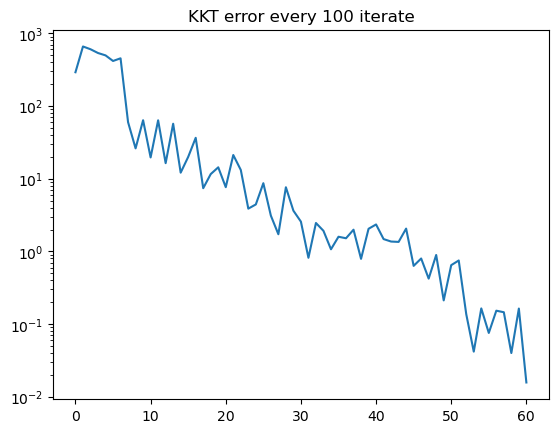

Restart at iteration 2 t= 2
Restart at iteration 1001 t= 999
0.9166755792793101
Restart at iteration 2001 t= 1000
0.4095593317179509
Restart at iteration 3001 t= 1000
0.2643977979453297
Restart at iteration 4001 t= 1000
0.18420847826997916
Restart at iteration 5001 t= 1000
0.0734512979741498
Restart at iteration 6001 t= 1000
0.04652212882847385
Restart at iteration 7001 t= 1000
0.06765025884262092
Termination Criteria reached at iteration 7100


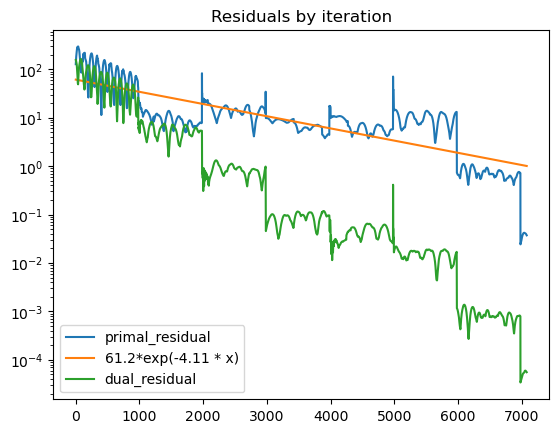

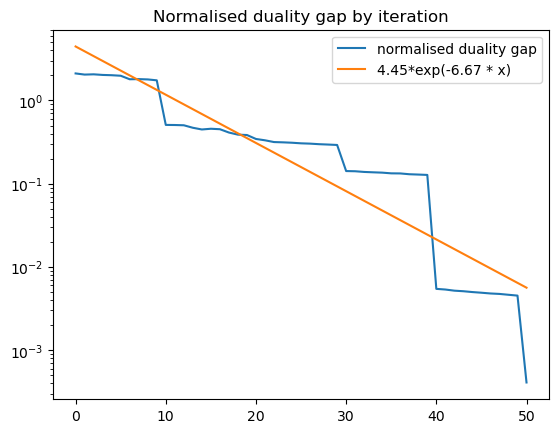

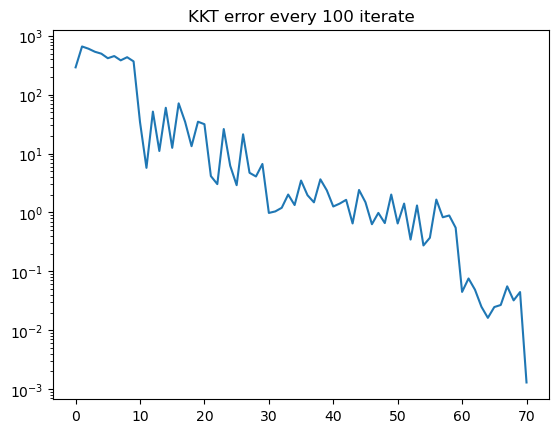

Restart at iteration 2 t= 2
Restart at iteration 1251 t= 1249
0.9166755792793101
Restart at iteration 2501 t= 1250
0.40440442974957747
Restart at iteration 3751 t= 1250
0.2524189910120953
Restart at iteration 5001 t= 1250
0.1731120092038236
Restart at iteration 6251 t= 1250
0.06823550471977459
Restart at iteration 7501 t= 1250
0.06058839786404592
Termination Criteria reached at iteration 8600


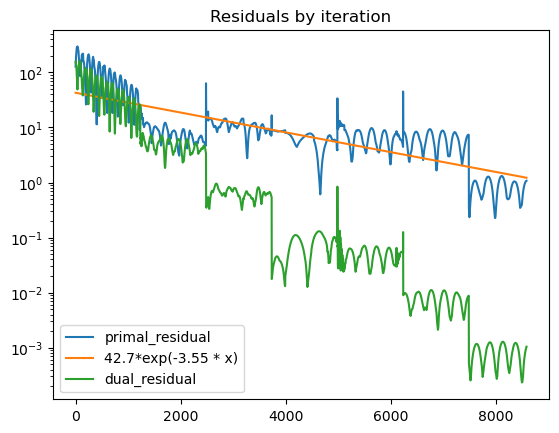

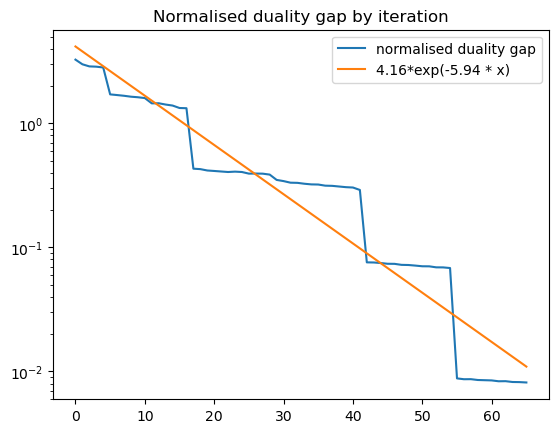

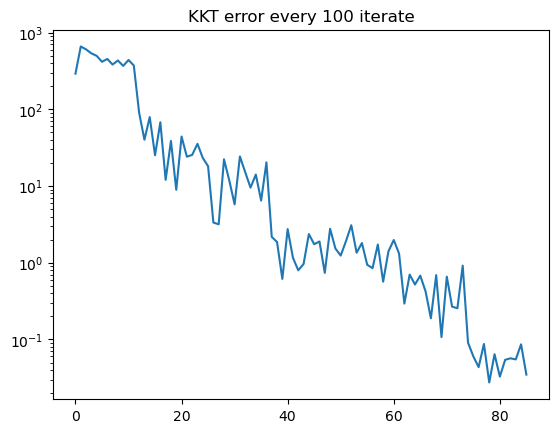

Restart at iteration 2 t= 2
Restart at iteration 1501 t= 1499
0.9166755792793101
Restart at iteration 3001 t= 1500
0.4021543819548017
Restart at iteration 4501 t= 1500
0.24984276639018393
Restart at iteration 6001 t= 1500
0.12375451138622338
Restart at iteration 7501 t= 1500
0.05686836290950341
Restart at iteration 9001 t= 1500
0.05238584315699254
Termination Criteria reached at iteration 9100


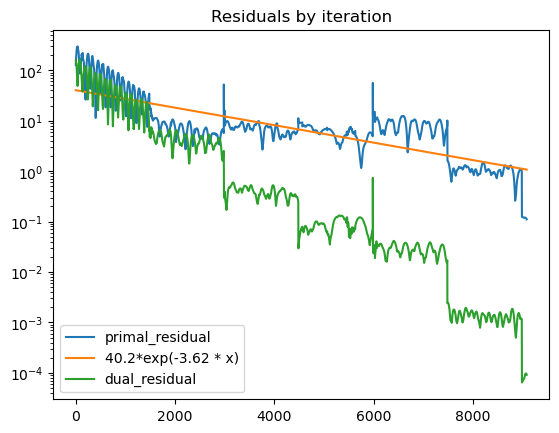

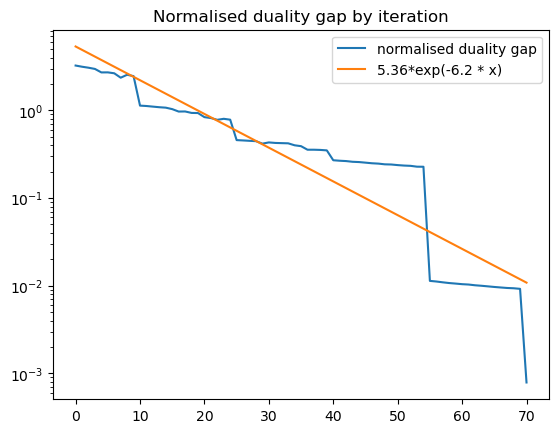

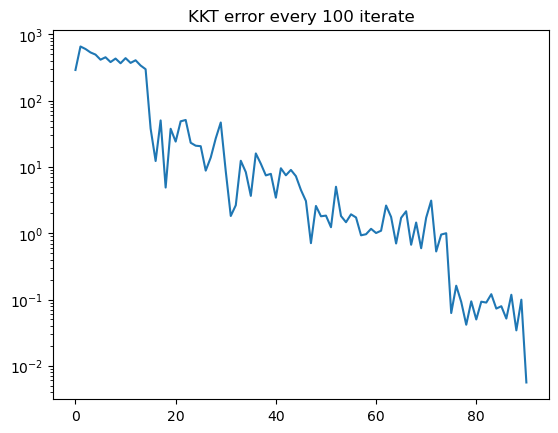

Restart at iteration 2 t= 2
Restart at iteration 1751 t= 1749
0.9166755792793101
Restart at iteration 3501 t= 1750
0.39906085996426316
Restart at iteration 5251 t= 1750
0.2508014087788246
Restart at iteration 7001 t= 1750
0.09648527265962144
Restart at iteration 8751 t= 1750
0.055337286349293136
Termination Criteria reached at iteration 9200


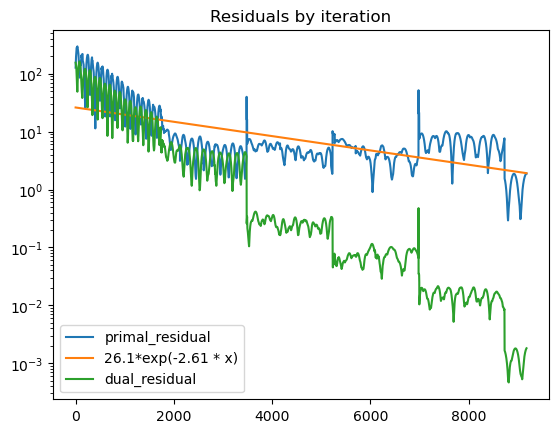

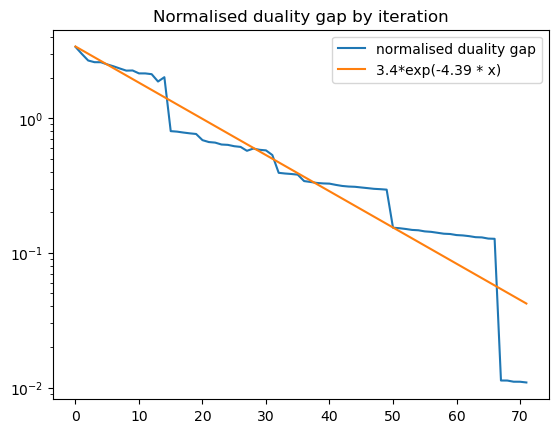

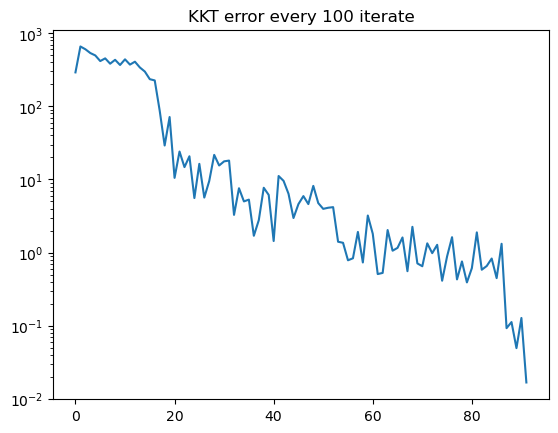

Restart at iteration 2 t= 2
Restart at iteration 2001 t= 1999
0.9166755792793101
Restart at iteration 4001 t= 2000
0.39645023217034303
Restart at iteration 6001 t= 2000
0.24496792284621427
Restart at iteration 8001 t= 2000
0.08065510454671955
Restart at iteration 10001 t= 2000
0.04908561123627533
Termination Criteria reached at iteration 10100


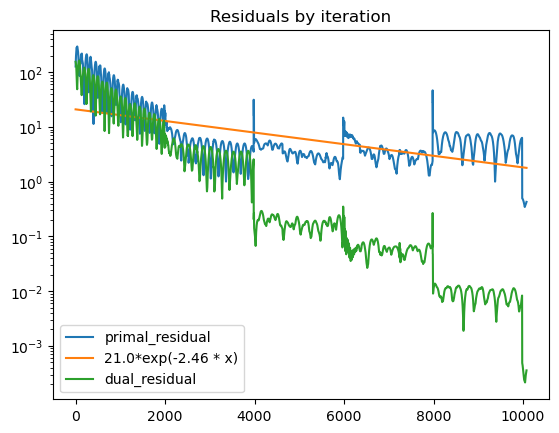

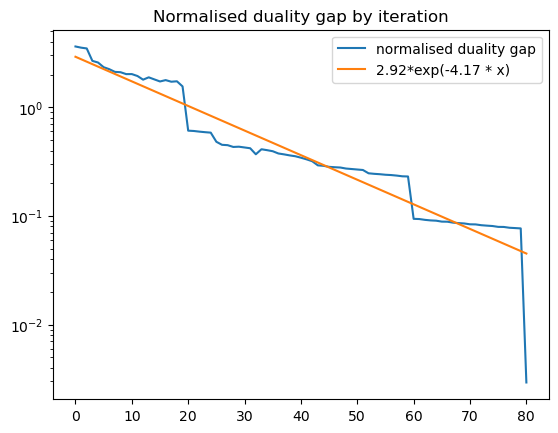

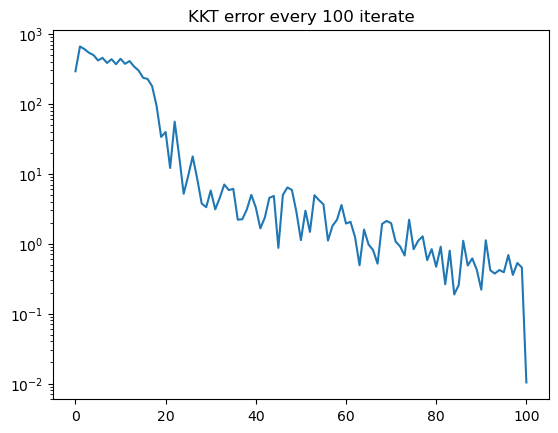

Restart at iteration 2 t= 2
Restart at iteration 2251 t= 2249
0.9166755792793101
Restart at iteration 4501 t= 2250
0.393879269059844
Restart at iteration 6751 t= 2250
0.24194308224155567
Restart at iteration 9001 t= 2250
0.07275530476731405
Restart at iteration 11251 t= 2250
0.0480344763309449
Termination Criteria reached at iteration 11400


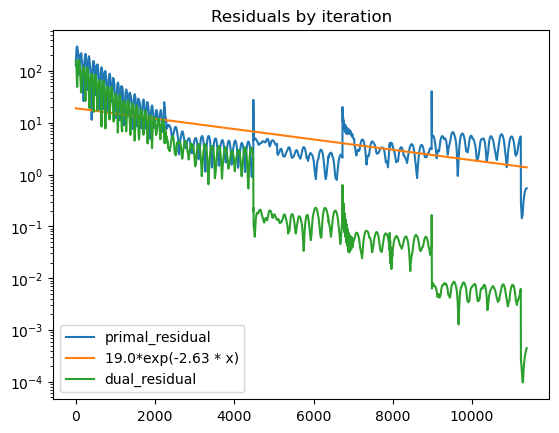

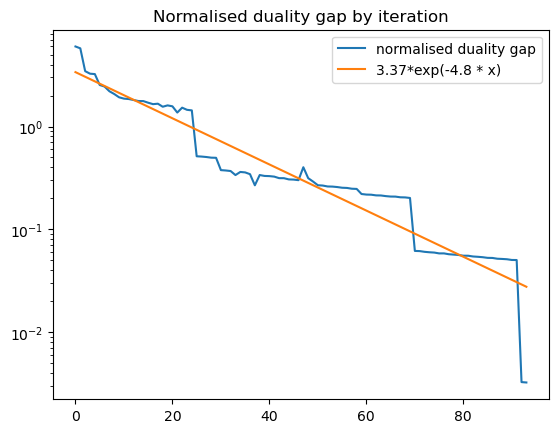

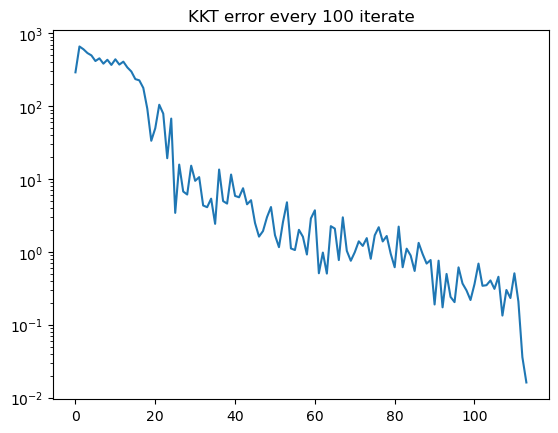

min_restart_length  num_iter
0                 250      6000
1                 500      4900
2                 750      6100
3                1000      7100
4                1250      8600
5                1500      9100
6                1750      9200
7                2000     10100
8                2250     11400

In [201]:
z0=np.zeros((dim+m1+m2,1))
break_val=100000
results=dict()
for restart in [250*i for i in range(1,10)]:
    x,y,k=PDLP(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-4,
                                    break_val=break_val, tau0=1,verbose=False,n_before_print=1000,min_restart=restart)
    results[restart]=k

In [ ]:
temp=pd.DataFrame(results.values(),results.keys()).reset_index().rename({'index':'min_restart_length',0:'num_iter'},axis=1)
display(temp)

# Convergence visualization

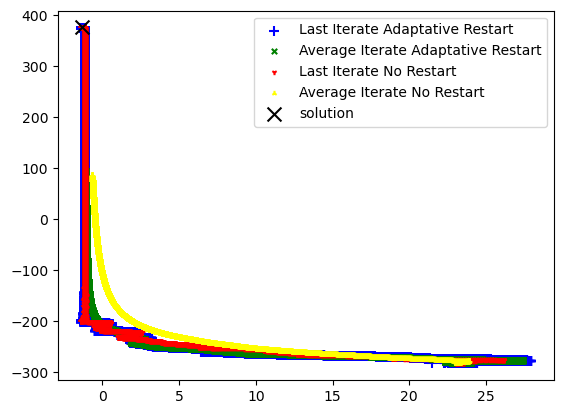

In [126]:
VisuIterate([list_last,list_average,list_last1,list_average1],x1,y1,dim,m1,m2,0,-1,ss=[50,15,15,15],
            zorders=[0,0,0,0],colors=None,markers=None,labels=['Last Iterate Adaptative Restart',
                            'Average Iterate Adaptative Restart','Last Iterate No Restart','Average Iterate No Restart'])

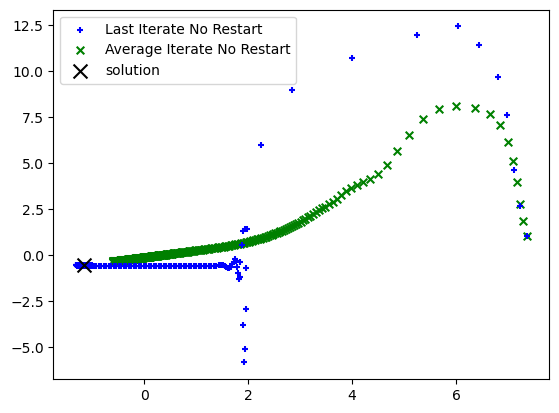

In [171]:
VisuIterate([list_last2,list_average2],x2,y2,dim,m1,m2,0,-1,ss=[15,30],zorders=[10,0],labels=['Last Iterate No Restart','Average Iterate No Restart'])

In [246]:
check_solution(x,c,A,G,h,b,l,tol=10**-4)

Minimum found: 1215.245903566164

Inequality constraints verified: 289 / 289 
Gx= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.29591493e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.09606901e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.51718654e-13  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.03080105e-06
   0.00000000e+00  1.91160510e-09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000000

In [302]:
check_solution(x3,c,A,G,h,b,l,tol=10**-4)

Minimum found: 1214.9091368781556

Inequality constraints verified: 279 / 289 
Gx= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.58654820e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.37509552e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.13408130e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.21691516e-03
   0.00000000e+00  2.10169078e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

# Random stepsize PDHG

In [57]:
z0=np.zeros((dim+m1+m2,1))
break_val=2000
#z0=np.vstack([primal_solution,dual_solution])+0.0001*np.random.rand(7,1)
x,y,t,list_z,list_primal_res,list_dual_res=PDHG(z0=z0, c=c, G=G, A=A, b=b,h=h, l=l, u=u, tol=10**-8,break_val=break_val, verbose= False,random_step_size=True)


Iteration:  0
tau, sigma: 0.3008962849315354 0.3008962849315354 0.09053857428559975 0.09053857428559975
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration:  100
tau, sigma: 1.4168509430643832 0.06390126973397905 0.09053857428559975 0.09053857428559975
[[0.99171784]
 [0.        ]
 [6.        ]
 [2.00938188]
 [4.16726905]
 [0.        ]
 [0.45557929]]
Iteration:  200
tau, sigma: 1.4408739252295695 0.06283587529781591 0.09053857428559975 0.09053857428559975
[[0.9932269 ]
 [0.        ]
 [6.        ]
 [2.00767244]
 [3.97118659]
 [0.        ]
 [0.50765182]]
Iteration:  300
tau, sigma: 1.3879404283355188 0.06523232008896644 0.09053857428559975 0.09053857428559975
[[1.00086205]
 [0.        ]
 [6.        ]
 [1.99902349]
 [4.00442058]
 [0.        ]
 [0.49882605]]
Iteration:  400
tau, sigma: 1.1492994124203544 0.07877718661226063 0.09053857428559975 0.09053857428559975
[[0.99975085]
 [0.        ]
 [6.        ]
 [2.00028224]
 [3.99961976]
 [0.        ]
 [0.50010098]]
Iteration:  500
tau, sigma: 1